# 🚴‍♂️ Predicción de Demanda de Bicicletas Compartidas
## Proyecto de Machine Learning - Sección 753, Universidad de Lima

### 👥 **Integrantes del Equipo**

| **Integrante** | **Responsabilidad** |
|----------------|-------------------|
| **Renzo Aguilar** | Fase de Análisis de Datos |
| **Franco Melchor y Carlos Minauro** | Fase de Preprocesamiento y Tratamiento de Datos |
| **Marcelo Landa** | Fase de Modelado |
| **Alejandro Toribio** | Fase de Optimización |

---

## 📊 **Descripción del Dataset y Problema**

### **Bike Sharing Dataset - UCI Machine Learning Repository**

Este proyecto aborda la **predicción de demanda de bicicletas compartidas** utilizando datos históricos de un sistema de bicicletas públicas. El objetivo es desarrollar modelos de regresión que puedan predecir con precisión cuántas bicicletas serán demandadas en diferentes condiciones temporales y meteorológicas.

### **🎯 Variable Objetivo (Target)**
- **`cnt`**: Demanda total de bicicletas (variable continua)
  - Representa el número total de bicicletas alquiladas por hora
  - Rango: 1 - 977 bicicletas por hora
  - **Problema de regresión supervisada**

### **📋 Características (Features) del Dataset**

#### **Variables Temporales:**
- **`season`**: Estación del año (1: primavera, 2: verano, 3: otoño, 4: invierno)
- **`yr`**: Año (0: 2011, 1: 2012)
- **`mnth`**: Mes del año (1-12)
- **`hr`**: Hora del día (0-23)
- **`weekday`**: Día de la semana (0: domingo, 6: sábado)
- **`workingday`**: Día laborable (0: fin de semana/festivo, 1: día laborable)
- **`holiday`**: Día festivo (0: no festivo, 1: festivo)

#### **Variables Meteorológicas:**
- **`weathersit`**: Condición climática
  - 1: Despejado/parcialmente nublado
  - 2: Nublado/neblina
  - 3: Lluvia ligera/nieve ligera
  - 4: Lluvia/nieve intensa
- **`temp`**: Temperatura normalizada (0-1)
- **`atemp`**: Sensación térmica normalizada (0-1)
- **`hum`**: Humedad relativa normalizada (0-1)
- **`windspeed`**: Velocidad del viento normalizada (0-1)

### **🔬 Tipo de Problema**
- **Regresión Supervisada**: Predecir valores continuos de demanda
- **Series Temporales**: Datos con componente temporal por horas
- **Multivariante**: Múltiples variables predictoras
- **Aplicación Real**: Optimización operativa de sistemas de transporte público

### **💡 Justificación del Modelo de Regresión**
El problema requiere **modelos de regresión** porque:
1. La variable objetivo (`cnt`) es **continua** (no categórica)
2. Necesitamos predecir **valores numéricos exactos** de demanda
3. Los modelos deben capturar **relaciones complejas** entre variables temporales y meteorológicas
4. La precisión en la predicción permite **optimización operativa** (redistribución, mantenimiento, inventario)

---

## 📚 Importación de Librerías y Configuración del Entorno

In [1]:
# IMPORTS Y CONFIGURACIÓN GLOBAL PARA REGRESIÓN
# ===============================================

# === LIBRERÍAS BÁSICAS ===
import warnings
import numpy as np
import pandas as pd

# === VISUALIZACIÓN ===
import matplotlib.pyplot as plt
import seaborn as sns

# === DATOS ===
from ucimlrepo import fetch_ucirepo

# === MODELOS DE REGRESIÓN ===
# Support Vector Machine
from sklearn.svm import SVR

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgb

# Redes Neuronales
from sklearn.neural_network import MLPRegressor

# Bagging
from sklearn.ensemble import BaggingRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

# Voting
from sklearn.ensemble import VotingRegressor

# === MÉTRICAS DE REGRESIÓN ===
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# === PREPROCESAMIENTO Y VALIDACIÓN ===
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score,
    KFold
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# === ANÁLISIS ESTADÍSTICO ===
from scipy import stats
import scipy.stats as stats

# === CONFIGURACIÓN GLOBAL ===
# Silenciar warnings no críticos
warnings.filterwarnings('ignore')

# Estilos de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)

print("✅ Librerías para REGRESIÓN importadas y configuración completada")
print("🤖 Modelos disponibles: SVM, Decision Tree, Random Forest, XGBoost, Neural Networks, Bagging, Boosting, Voting")

✅ Librerías para REGRESIÓN importadas y configuración completada
🤖 Modelos disponibles: SVM, Decision Tree, Random Forest, XGBoost, Neural Networks, Bagging, Boosting, Voting


## Funciones Plot de Apoyo

In [2]:
def plot_distribution(data, columns, figsize=(15, 10)):
    """
    Visualiza la distribución de variables para análisis de regresión
    """
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma simple para variables numéricas
            axes[i].hist(data[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].grid(alpha=0.3)
            
            # Agregar estadísticas básicas
            mean_val = data[col].mean()
            median_val = data[col].median()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.2f}')
            axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.2f}')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr(numeric_only=True)
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, figsize=(15, 10)):
    """
    Detecta y visualiza outliers en variables numéricas usando boxplots
    """
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Boxplot para detectar outliers
            box_plot = axes[i].boxplot(data[col], patch_artist=True)
            box_plot['boxes'][0].set_facecolor('lightblue')
            axes[i].set_title(f'Outliers en {col}')
            axes[i].set_ylabel(col)
            axes[i].grid(alpha=0.3)
            
            # Calcular y mostrar estadísticas de outliers
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
            
            axes[i].text(0.02, 0.98, f'Outliers: {len(outliers)}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_target_distribution(y, title="Distribución de la Variable Objetivo", figsize=(12, 5)):
    """
    Analiza y visualiza la distribución de la variable objetivo para regresión
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    # Histograma
    ax1.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title(f'{title} - Histograma')
    ax1.set_xlabel('Valor')
    ax1.set_ylabel('Frecuencia')
    ax1.grid(alpha=0.3)
    
    # Agregar estadísticas
    mean_val = y.mean()
    median_val = y.median()
    ax1.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.2f}')
    ax1.axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.2f}')
    ax1.legend()
    
    # Boxplot
    box_plot = ax2.boxplot(y, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightgreen')
    ax2.set_title(f'{title} - Boxplot')
    ax2.set_ylabel('Valor')
    ax2.grid(alpha=0.3)
    
    # QQ Plot para normalidad
    from scipy import stats
    stats.probplot(y, dist="norm", plot=ax3)
    ax3.set_title(f'{title} - Q-Q Plot')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir estadísticas
    print(f"📊 ESTADÍSTICAS DE LA VARIABLE OBJETIVO:")
    print(f"   • Media: {y.mean():.2f}")
    print(f"   • Mediana: {y.median():.2f}")
    print(f"   • Desviación estándar: {y.std():.2f}")
    print(f"   • Mínimo: {y.min():.2f}")
    print(f"   • Máximo: {y.max():.2f}")
    print(f"   • Rango: {y.max() - y.min():.2f}")
    print(f"   • Asimetría: {y.skew():.2f}")
    print(f"   • Curtosis: {y.kurtosis():.2f}")
    
    # Test de normalidad
    shapiro_stat, shapiro_p = stats.shapiro(y.sample(min(5000, len(y))))
    print(f"   • Test de Shapiro-Wilk (normalidad): p-value = {shapiro_p:.2e}")
    if shapiro_p > 0.05:
        print("     ✅ Los datos siguen una distribución normal")
    else:
        print("     ❌ Los datos NO siguen una distribución normal")

def evaluate_regression_model(model, X_test, y_test, y_pred, model_name):
    """
    Evalúa un modelo de regresión con múltiples métricas
    """
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Calcular métricas adicionales
    mean_y = np.mean(y_test)
    ss_res = np.sum((y_test - y_pred) ** 2)
    ss_tot = np.sum((y_test - mean_y) ** 2)
    adjusted_r2 = 1 - (ss_res / ss_tot) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Adjusted_R²': adjusted_r2,
        'MAPE': mape,
        'predictions': y_pred
    }
    
    return results

def plot_regression_results(models_results, y_test, figsize=(15, 12)):
    """
    Visualiza los resultados de múltiples modelos de regresión
    """
    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            
            # Scatter plot: Valores reales vs predichos
            axes[i].scatter(y_test, y_pred, alpha=0.6, color='blue')
            
            # Línea de referencia perfecta (y = x)
            min_val = min(y_test.min(), y_pred.min())
            max_val = max(y_test.max(), y_pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
            
            axes[i].set_title(f'{model_name}\nR² = {results["R²"]:.3f}, RMSE = {results["RMSE"]:.2f}')
            axes[i].set_xlabel('Valores Reales')
            axes[i].set_ylabel('Valores Predichos')
            axes[i].grid(alpha=0.3)
            
            # Calcular límites iguales para ambos ejes
            all_values = np.concatenate([y_test, y_pred])
            margin = (all_values.max() - all_values.min()) * 0.05
            axes[i].set_xlim(all_values.min() - margin, all_values.max() + margin)
            axes[i].set_ylim(all_values.min() - margin, all_values.max() + margin)
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_residuals_analysis(models_results, y_test, figsize=(15, 12)):
    """
    Análisis de residuos para modelos de regresión
    """
    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            residuals = y_test - y_pred
            
            # Gráfico de residuos vs valores predichos
            axes[i].scatter(y_pred, residuals, alpha=0.6, color='green')
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8)
            axes[i].set_title(f'Residuos - {model_name}')
            axes[i].set_xlabel('Valores Predichos')
            axes[i].set_ylabel('Residuos')
            axes[i].grid(alpha=0.3)
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def compare_models_metrics(models_results, figsize=(12, 8)):
    """
    Compara las métricas de diferentes modelos de regresión
    """
    # Crear DataFrame con las métricas
    metrics_data = []
    for model_name, results in models_results.items():
        metrics_data.append({
            'Model': model_name,
            'R²': results['R²'],
            'RMSE': results['RMSE'],
            'MAE': results['MAE'],
            'MAPE': results['MAPE']
        })
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Visualizar métricas
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # R²
    axes[0, 0].bar(df_metrics['Model'], df_metrics['R²'], color='skyblue')
    axes[0, 0].set_title('R² Score')
    axes[0, 0].set_ylabel('R²')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # RMSE
    axes[0, 1].bar(df_metrics['Model'], df_metrics['RMSE'], color='lightcoral')
    axes[0, 1].set_title('Root Mean Square Error')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # MAE
    axes[1, 0].bar(df_metrics['Model'], df_metrics['MAE'], color='lightgreen')
    axes[1, 0].set_title('Mean Absolute Error')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # MAPE
    axes[1, 1].bar(df_metrics['Model'], df_metrics['MAPE'], color='gold')
    axes[1, 1].set_title('Mean Absolute Percentage Error')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_metrics

# Fase 1: Exploratory Data Analysis

### 1.1 Carga de Datos

In [3]:
# 1.1 Carga de datos desde UCI ML Repository

# Obtener el dataset
bike_sharing = fetch_ucirepo(id=275)

# Extraer características y variable objetivo
X = bike_sharing.data.features
y = bike_sharing.data.targets

# Combinar en un solo DataFrame para el análisis
df = pd.concat([X, y], axis=1)

print(f"✅ Dataset cargado exitosamente!")
print(f"📈 Forma del dataset: {df.shape}")
print(f"🔗 Variables de entrada: {X.shape[1]}")
print(f"🎯 Variables objetivo: {y.shape[1]}")

✅ Dataset cargado exitosamente!
📈 Forma del dataset: (17379, 14)
🔗 Variables de entrada: 13
🎯 Variables objetivo: 1


### 1.2 Eliminar columna `dteday` por redundancia

In [4]:
drop_cols = ['dteday']
df = df.drop(columns=drop_cols)
print(f"Existen un total de {df.shape[1]} columnas después de eliminar las columnas innecesarias.")

Existen un total de 13 columnas después de eliminar las columnas innecesarias.


### 1.3 Forma del Dataset

In [5]:
# 1.2 Exploración inicial del dataset
print("🔍 EXPLORACIÓN INICIAL DEL DATASET")
print("=" * 50)

# Información general del dataset
print("📊 Información general:")
print(f"Forma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")

🔍 EXPLORACIÓN INICIAL DEL DATASET
📊 Información general:
Forma del dataset: (17379, 13)
Número de filas: 17,379
Número de columnas: 13


### 1.4 Primeras 5 filas del dataset

In [6]:
print("\n📋 Primeras 5 filas del dataset:")
display(df.head())


📋 Primeras 5 filas del dataset:


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### 1.5 Ultimas 5 filas del dataset

In [7]:
print("\n📋 Últimas 5 filas del dataset:")
display(df.tail())


📋 Últimas 5 filas del dataset:


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61
17378,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,49


### 1.6 Nombres de las columnas

In [8]:
print("\n🔗 Nombres de las columnas:")
print(df.columns.tolist())


🔗 Nombres de las columnas:
['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


### 1.7 Información detallada del dataset

In [9]:
# 1.3 Análisis de tipos de datos y valores faltantes
print("🔍 ANÁLISIS DE TIPOS DE DATOS Y CALIDAD")
print("=" * 50)

# Información detallada del dataset
print("📊 Información detallada:")
df.info()

🔍 ANÁLISIS DE TIPOS DE DATOS Y CALIDAD
📊 Información detallada:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


### 1.8 Tipos de datos

In [10]:
print("\n🔢 Tipos de datos:")
print(df.dtypes)


🔢 Tipos de datos:
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object


### 1.9 Valores nulos del dataset

In [11]:
print("\n❌ Valores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
})
print(missing_df)

print(f"\n📈 Total de valores faltantes: {df.isnull().sum().sum()}")
print(f"📊 Porcentaje total de valores faltantes: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")


❌ Valores faltantes por columna:
       Columna  Valores_Faltantes  Porcentaje
0       season                  0         0.0
1           yr                  0         0.0
2         mnth                  0         0.0
3           hr                  0         0.0
4      holiday                  0         0.0
5      weekday                  0         0.0
6   workingday                  0         0.0
7   weathersit                  0         0.0
8         temp                  0         0.0
9        atemp                  0         0.0
10         hum                  0         0.0
11   windspeed                  0         0.0
12         cnt                  0         0.0

📈 Total de valores faltantes: 0
📊 Porcentaje total de valores faltantes: 0.00%


### 1.10 Estadísticas para variables numéricas

In [12]:
# 1.4 Estadísticas descriptivas
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)

variables_numericas = ['temp','atemp','hum','windspeed','cnt']
# Estadísticas para variables numéricas
print("🔢 Variables numéricas:")
print(f"Columnas numéricas: {variables_numericas}")

print("\n📈 Estadísticas descriptivas de variables numéricas:")
display(df[variables_numericas].describe().round(4))

📊 ESTADÍSTICAS DESCRIPTIVAS
🔢 Variables numéricas:
Columnas numéricas: ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

📈 Estadísticas descriptivas de variables numéricas:


,temp,atemp,hum,windspeed,cnt
count,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000
mean,0.4970,0.4758,0.6272,0.1901,189.4631
std,0.1926,0.1719,0.1929,0.1223,181.3876
min,0.0200,0.0000,0.0000,0.0000,1.0000
25%,0.3400,0.3333,0.4800,0.1045,40.0000
50%,0.5000,0.4848,0.6300,0.1940,142.0000
75%,0.6600,0.6212,0.7800,0.2537,281.0000
max,1.0000,1.0000,1.0000,0.8507,977.0000


### 1.11 Estadísticas para variables OBJECT

In [13]:
# Estadísticas para variables categóricas
print("\n🏷️ Variables categóricas:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas: {categorical_cols}")

if categorical_cols:
    print("\n📊 Estadísticas descriptivas de variables categóricas:")
    display(df[categorical_cols].describe())
else:
    print("No hay variables categóricas de tipo object en el dataset.")


🏷️ Variables categóricas:
Columnas categóricas: []
No hay variables categóricas de tipo object en el dataset.


### 1.12 Información sobre la variable objetivo

In [14]:
# Información sobre la variable objetivo
print("\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (cnt - Total Rental Bikes)")
print(f"Media: {df['cnt'].mean():.2f}")
print(f"Mediana: {df['cnt'].median():.2f}")
print(f"Desviación estándar: {df['cnt'].std():.2f}")
print(f"Mínimo: {df['cnt'].min()}")
print(f"Máximo: {df['cnt'].max()}")
print(f"Rango: {df['cnt'].max() - df['cnt'].min()}")


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (cnt - Total Rental Bikes)
Media: 189.46
Mediana: 142.00
Desviación estándar: 181.39
Mínimo: 1
Máximo: 977
Rango: 976


### 1.13 Análisis de correlaciones

🔗 ANÁLISIS DE CORRELACIONES


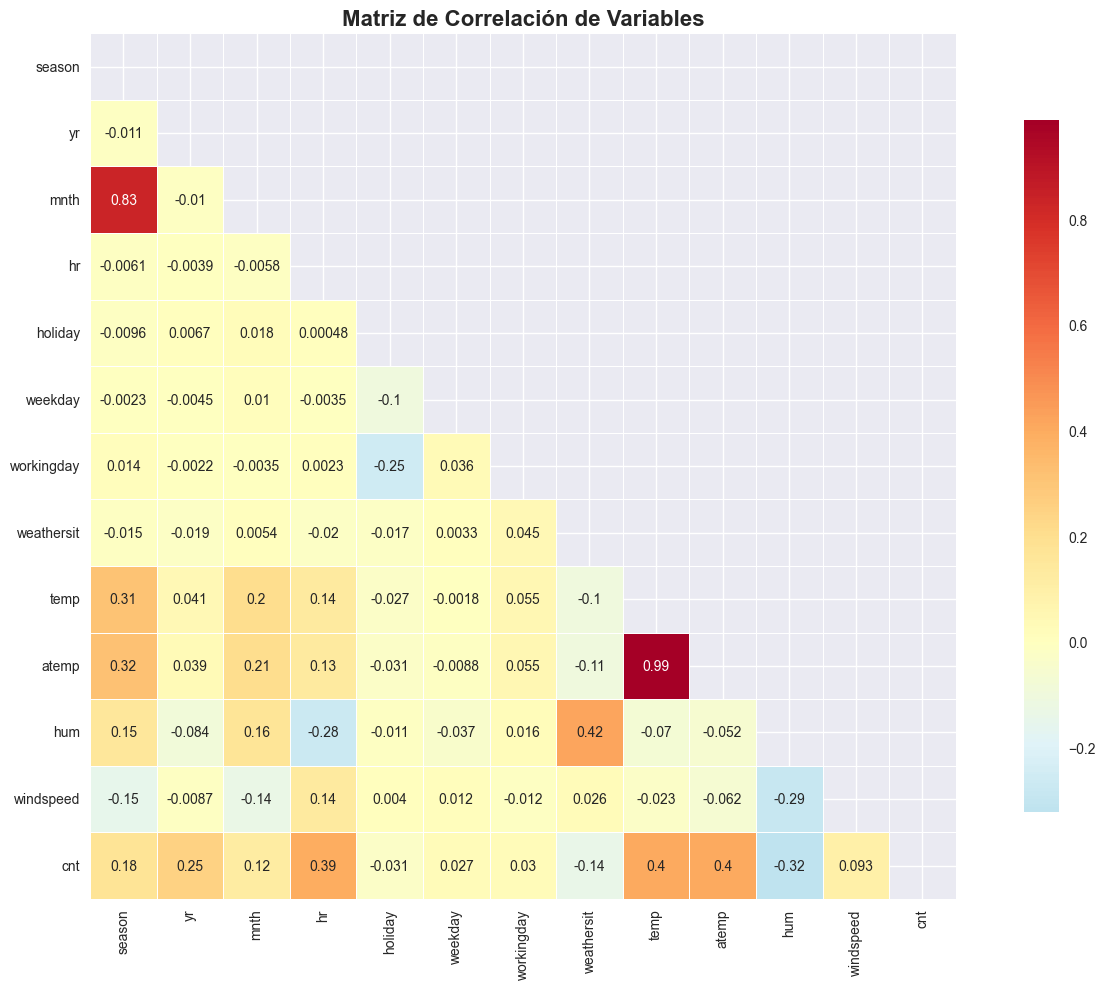


🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):
cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
hum          -0.322911
yr            0.250495
season        0.178056
weathersit   -0.142426
mnth          0.120638
windspeed     0.093234
holiday      -0.030927
workingday    0.030284
weekday       0.026900

📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:
• temp: 0.405 (correlación positiva)
• atemp: 0.401 (correlación positiva)
• hr: 0.394 (correlación positiva)
• hum: -0.323 (correlación negativa)
• yr: 0.250 (correlación positiva)

⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):
• season - mnth: 0.830
• temp - atemp: 0.988

🌡️ CORRELACIÓN TEMPERATURA vs TEMPERATURA APARENTE: 0.988
Esto indica una relación muy fuerte, se puede considerar usar solo una de estas variables.


In [15]:
# 1.5 Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

# Análisis específico entre temperatura y temperatura aparente
print(f"\n🌡️ CORRELACIÓN TEMPERATURA vs TEMPERATURA APARENTE: {correlation_matrix.loc['temp', 'atemp']:.3f}")
print("Esto indica una relación muy fuerte, se puede considerar usar solo una de estas variables.")

### 1.14 Detección y Análisis de Outliers

In [16]:
### 1.6 Identifique y reporte outliers en al menos 3 variables numéricas
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

main_features = ['temp', 'atemp', 'hum', 'windspeed']

outliers_info = detect_outliers_iqr(df, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")


⚠️  ANÁLISIS DE OUTLIERS:

📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • temp                     :   0 outliers
   • atemp                    :   0 outliers
   • hum                      :  22 outliers
   • windspeed                : 342 outliers



📊 VISUALIZACIÓN DE OUTLIERS:


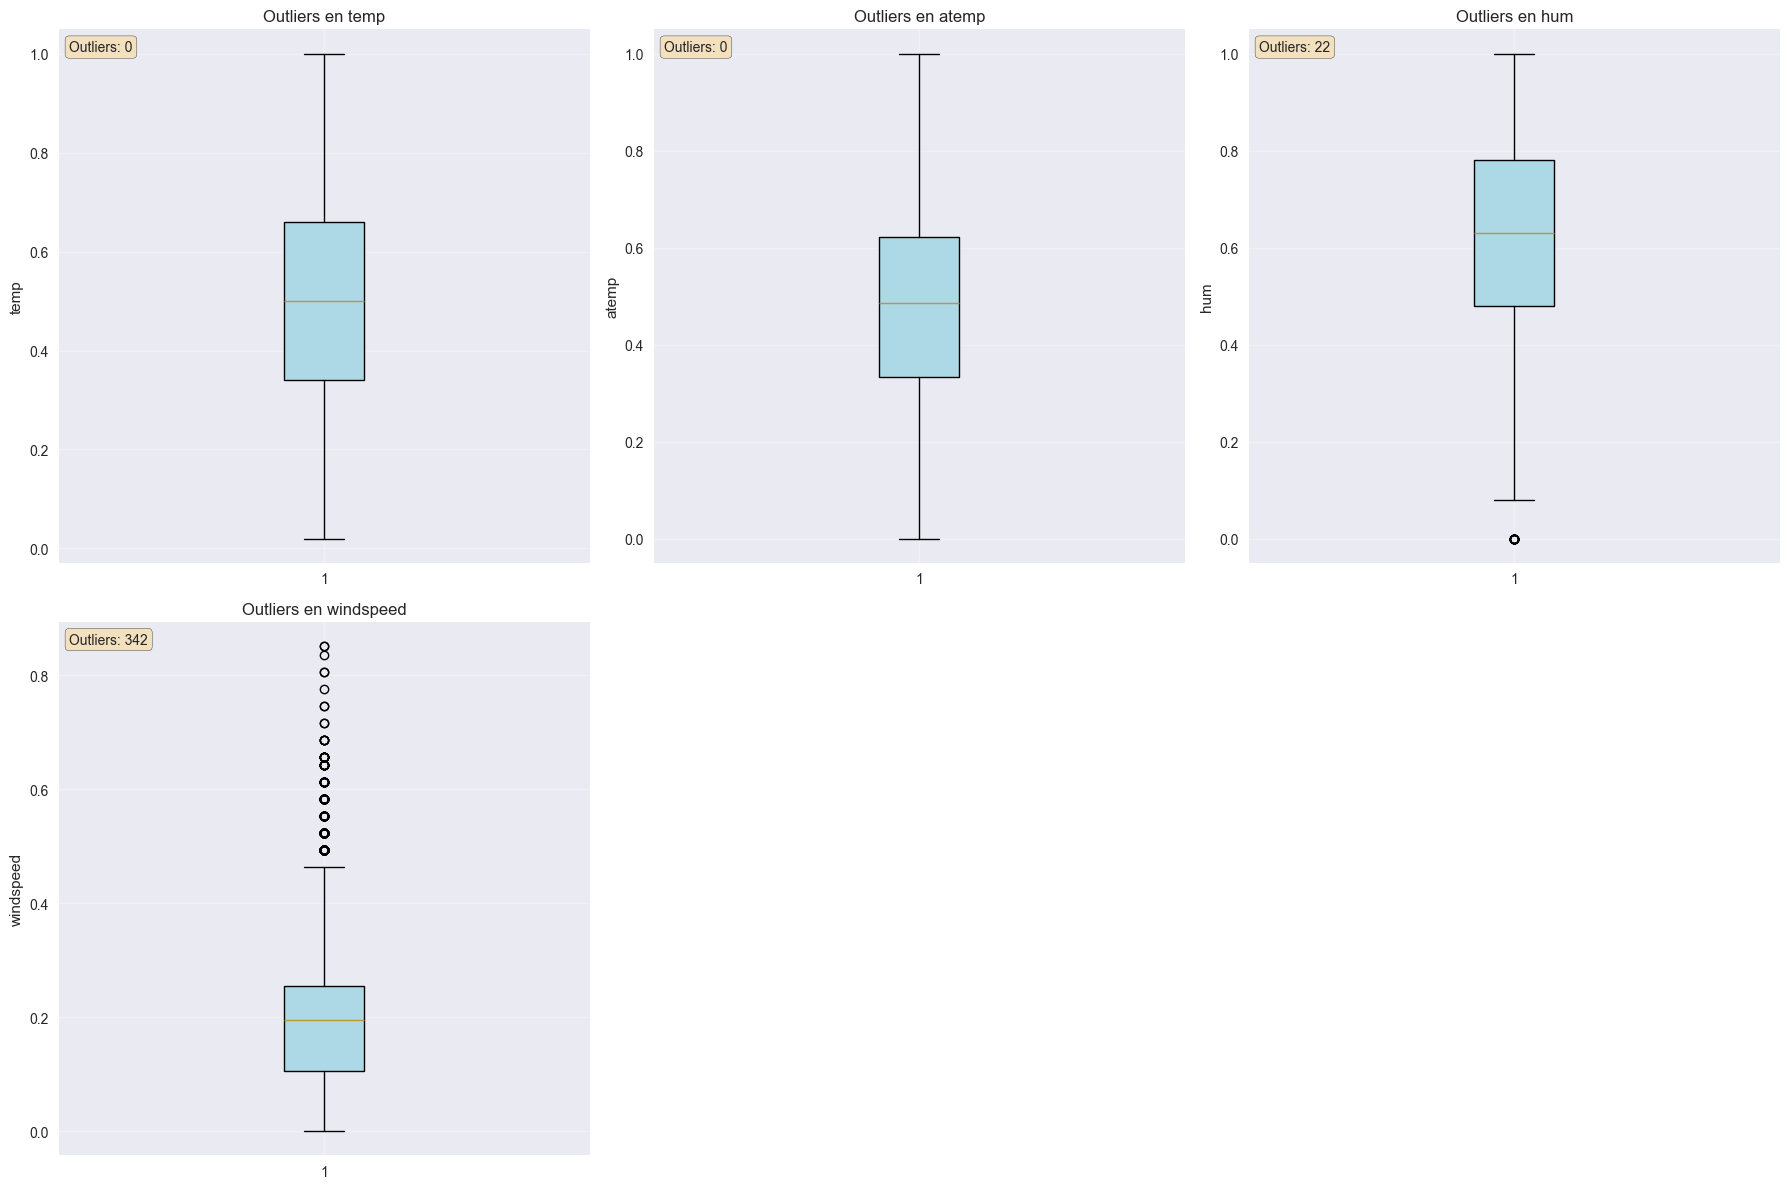

In [17]:
# Visualización de outliers usando nuestras funciones
print("\n📊 VISUALIZACIÓN DE OUTLIERS:")

# Variables numéricas principales para análisis de outliers
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']

# Usar la función plot_outliers definida anteriormente
plot_outliers(df, numeric_features, figsize=(18, 12))

### 1.15 Análisis de Distribuciones de Variables Numéricas

📈 ANÁLISIS DE DISTRIBUCIONES


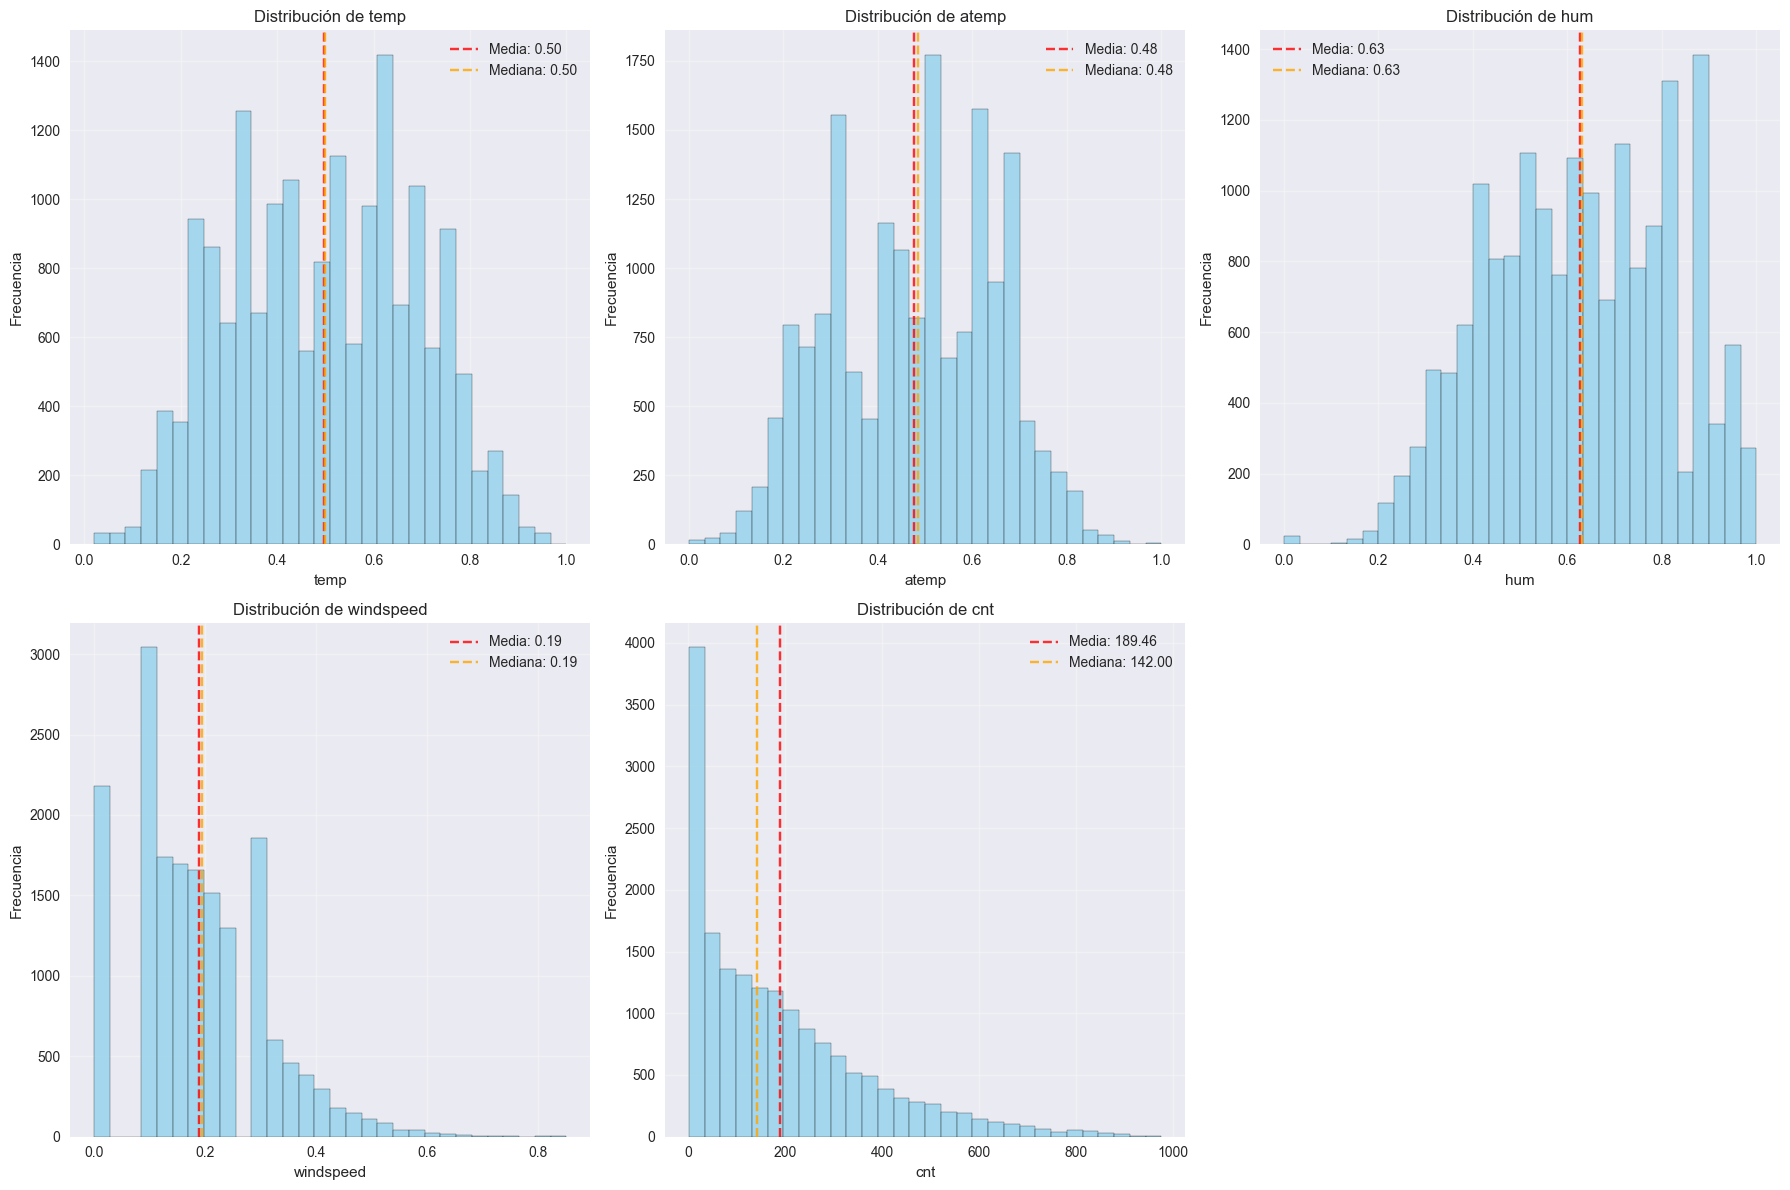


🎯 ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO (cnt):


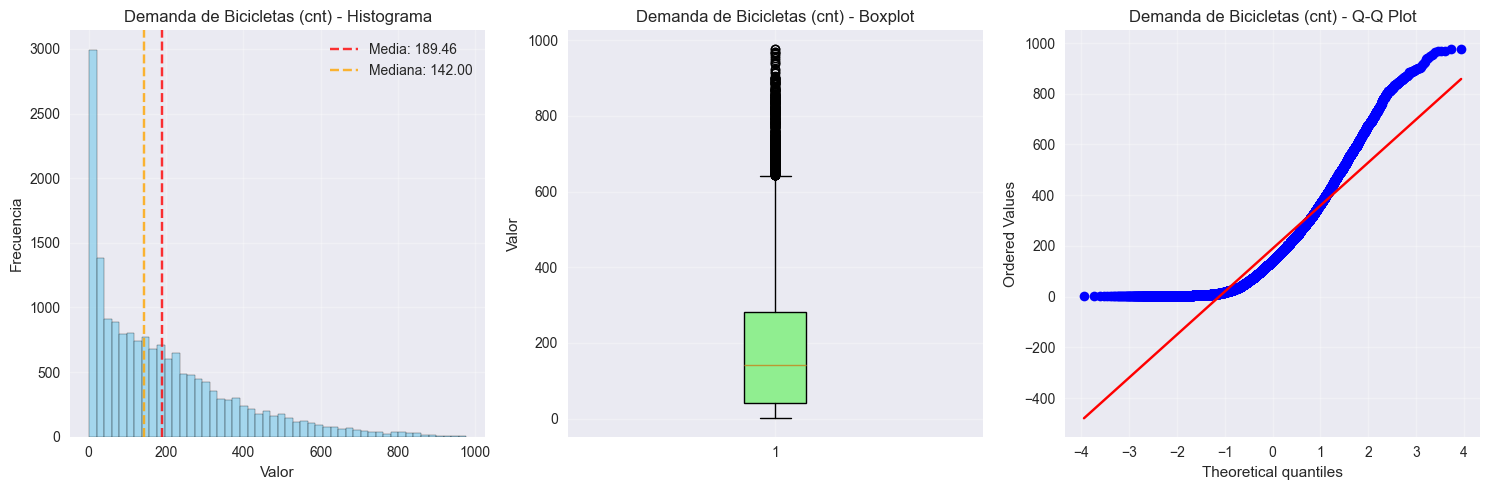

📊 ESTADÍSTICAS DE LA VARIABLE OBJETIVO:
   • Media: 189.46
   • Mediana: 142.00
   • Desviación estándar: 181.39
   • Mínimo: 1.00
   • Máximo: 977.00
   • Rango: 976.00
   • Asimetría: 1.28
   • Curtosis: 1.42
   • Test de Shapiro-Wilk (normalidad): p-value = 1.05e-53
     ❌ Los datos NO siguen una distribución normal


In [18]:
# 1.7 Análisis de distribuciones de variables numéricas
print("📈 ANÁLISIS DE DISTRIBUCIONES")
print("=" * 50)

# Variables numéricas para analizar
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Usar función para mostrar distribuciones
plot_distribution(df, numeric_vars, figsize=(18, 12))

# Análisis específico de la variable objetivo
print("\n🎯 ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO (cnt):")
plot_target_distribution(df['cnt'], title="Demanda de Bicicletas (cnt)", figsize=(15, 5))

### 1.16 Análisis Temporal de la Demanda

In [19]:
# 1.8 Análisis temporal de la demanda
print("⏰ ANÁLISIS TEMPORAL DE LA DEMANDA")
print("=" * 50)

# Crear mapeos para mejor interpretación
season_names = {1: 'Primavera', 2: 'Verano', 3: 'Otoño', 4: 'Invierno'}
weather_names = {1: 'Despejado', 2: 'Nublado', 3: 'Lluvia ligera', 4: 'Lluvia fuerte'}
year_names = {0: '2011', 1: '2012'}
weekday_names = {0: 'Domingo', 1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sábado'}
workingday_names = {0: 'No laborable', 1: 'Laborable'}
holiday_names = {0: 'No festivo', 1: 'Festivo'}

# Análisis por estación del año
print("\n🌸 DEMANDA PROMEDIO POR ESTACIÓN:")
season_avg = df.groupby('season')['cnt'].mean().sort_values(ascending=False)
for season_code, avg_demand in season_avg.items():
    print(f"• {season_names[season_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por año
print("\n📅 DEMANDA PROMEDIO POR AÑO:")
year_avg = df.groupby('yr')['cnt'].mean()
for year_code, avg_demand in year_avg.items():
    print(f"• {year_names[year_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por día de la semana
print("\n📆 DEMANDA PROMEDIO POR DÍA DE LA SEMANA:")
weekday_avg = df.groupby('weekday')['cnt'].mean()
for weekday_code, avg_demand in weekday_avg.items():
    print(f"• {weekday_names[weekday_code]}: {avg_demand:.1f} bicicletas/hora")

# Análisis por hora del día
print("\n🕐 DEMANDA PROMEDIO POR HORA DEL DÍA:")
hourly_avg = df.groupby('hr')['cnt'].mean()
print(f"Hora con mayor demanda: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.1f} bicicletas)")
print(f"Hora con menor demanda: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.1f} bicicletas)")

# Análisis por mes
print("\n📊 DEMANDA PROMEDIO POR MES:")
monthly_avg = df.groupby('mnth')['cnt'].mean()
print(f"Mes con mayor demanda: {monthly_avg.idxmax()} ({monthly_avg.max():.1f} bicicletas/hora)")
print(f"Mes con menor demanda: {monthly_avg.idxmin()} ({monthly_avg.min():.1f} bicicletas/hora)")

# Análisis días laborables vs no laborables
print("\n💼 DEMANDA: DÍAS LABORABLES VS NO LABORABLES:")
workingday_comparison = df.groupby('workingday')['cnt'].agg(['mean', 'std', 'count'])
for workingday_code in workingday_comparison.index:
    stats = workingday_comparison.loc[workingday_code]
    print(f"• {workingday_names[workingday_code]}: {stats['mean']:.1f} ± {stats['std']:.1f} bicicletas/hora (n={stats['count']})")

# Análisis condiciones climáticas
print("\n🌤️ DEMANDA PROMEDIO POR CONDICIONES CLIMÁTICAS:")
weather_avg = df.groupby('weathersit')['cnt'].mean().sort_values(ascending=False)
for weather_code, avg_demand in weather_avg.items():
    print(f"• {weather_names[weather_code]}: {avg_demand:.1f} bicicletas/hora")

⏰ ANÁLISIS TEMPORAL DE LA DEMANDA

🌸 DEMANDA PROMEDIO POR ESTACIÓN:
• Otoño: 236.0 bicicletas/hora
• Verano: 208.3 bicicletas/hora
• Invierno: 198.9 bicicletas/hora
• Primavera: 111.1 bicicletas/hora

📅 DEMANDA PROMEDIO POR AÑO:
• 2011: 143.8 bicicletas/hora
• 2012: 234.7 bicicletas/hora

📆 DEMANDA PROMEDIO POR DÍA DE LA SEMANA:
• Domingo: 177.5 bicicletas/hora
• Lunes: 183.7 bicicletas/hora
• Martes: 191.2 bicicletas/hora
• Miércoles: 191.1 bicicletas/hora
• Jueves: 196.4 bicicletas/hora
• Viernes: 196.1 bicicletas/hora
• Sábado: 190.2 bicicletas/hora

🕐 DEMANDA PROMEDIO POR HORA DEL DÍA:
Hora con mayor demanda: 17:00 (461.5 bicicletas)
Hora con menor demanda: 4:00 (6.4 bicicletas)

📊 DEMANDA PROMEDIO POR MES:
Mes con mayor demanda: 9 (240.8 bicicletas/hora)
Mes con menor demanda: 1 (94.4 bicicletas/hora)

💼 DEMANDA: DÍAS LABORABLES VS NO LABORABLES:
• No laborable: 181.4 ± 172.9 bicicletas/hora (n=5514.0)
• Laborable: 193.2 ± 185.1 bicicletas/hora (n=11865.0)

🌤️ DEMANDA PROMEDIO POR

### 1.17 Visualizaciones Temporales


📊 VISUALIZACIONES TEMPORALES:


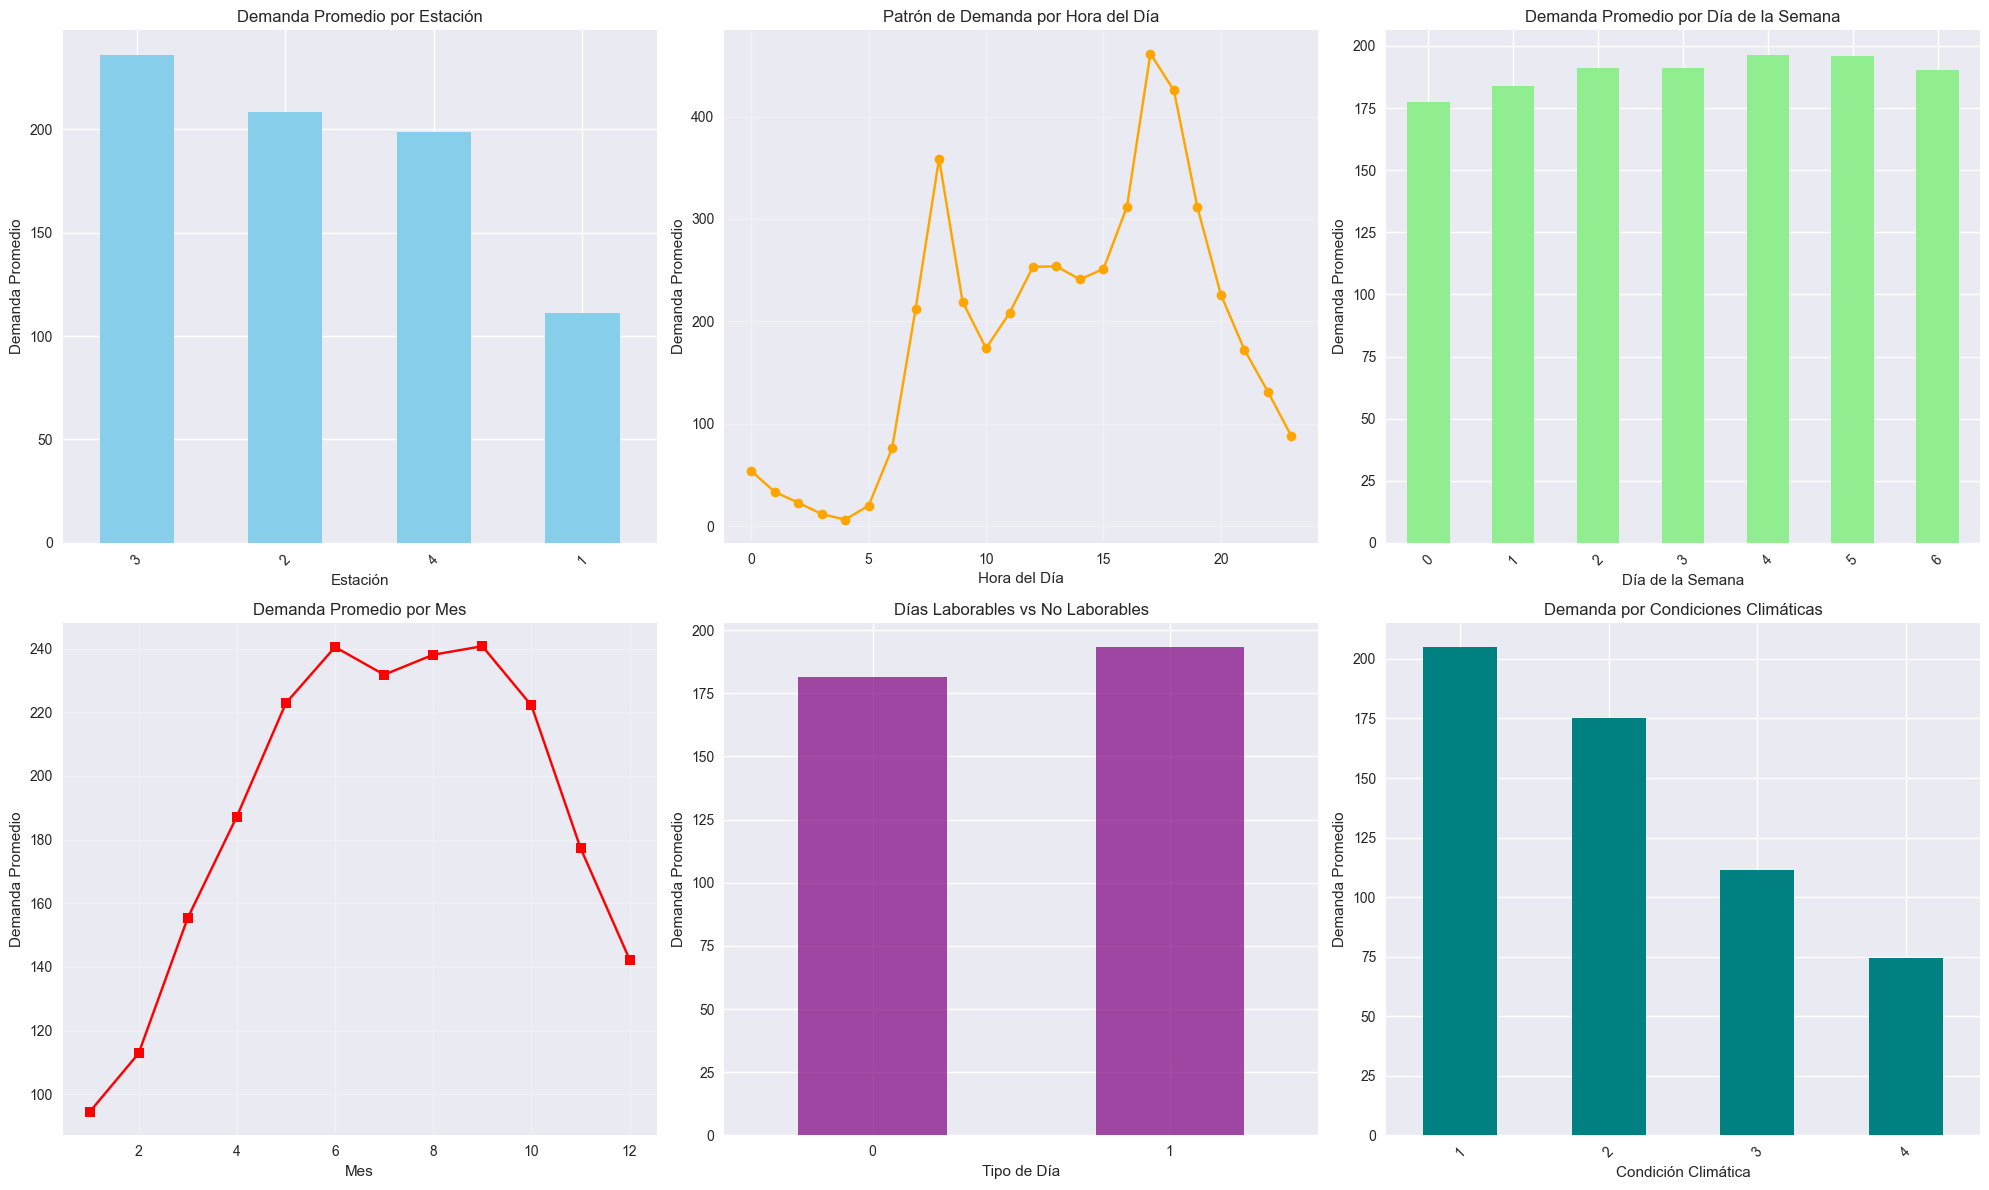

In [20]:
# Visualizaciones temporales
print("\n📊 VISUALIZACIONES TEMPORALES:")

# Crear visualizaciones en una sola figura
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Demanda por estación
season_avg.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Demanda Promedio por Estación')
axes[0, 0].set_xlabel('Estación')
axes[0, 0].set_ylabel('Demanda Promedio')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Demanda por hora del día
hourly_avg.plot(kind='line', ax=axes[0, 1], color='orange', marker='o')
axes[0, 1].set_title('Patrón de Demanda por Hora del Día')
axes[0, 1].set_xlabel('Hora del Día')
axes[0, 1].set_ylabel('Demanda Promedio')
axes[0, 1].grid(True, alpha=0.3)

# 3. Demanda por día de la semana
weekday_avg.plot(kind='bar', ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Demanda Promedio por Día de la Semana')
axes[0, 2].set_xlabel('Día de la Semana')
axes[0, 2].set_ylabel('Demanda Promedio')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Demanda por mes
monthly_avg.plot(kind='line', ax=axes[1, 0], color='red', marker='s')
axes[1, 0].set_title('Demanda Promedio por Mes')
axes[1, 0].set_xlabel('Mes')
axes[1, 0].set_ylabel('Demanda Promedio')
axes[1, 0].grid(True, alpha=0.3)

# 5. Comparación días laborables
workingday_comparison['mean'].plot(kind='bar', ax=axes[1, 1], color='purple', alpha=0.7)
axes[1, 1].set_title('Días Laborables vs No Laborables')
axes[1, 1].set_xlabel('Tipo de Día')
axes[1, 1].set_ylabel('Demanda Promedio')
axes[1, 1].tick_params(axis='x', rotation=0)

# 6. Condiciones climáticas
weather_avg.plot(kind='bar', ax=axes[1, 2], color='teal')
axes[1, 2].set_title('Demanda por Condiciones Climáticas')
axes[1, 2].set_xlabel('Condición Climática')
axes[1, 2].set_ylabel('Demanda Promedio')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 1.18 Analsis de relaciones climaticas vs demanda

🌡️ ANÁLISIS DE RELACIONES CLIMÁTICAS VS DEMANDA


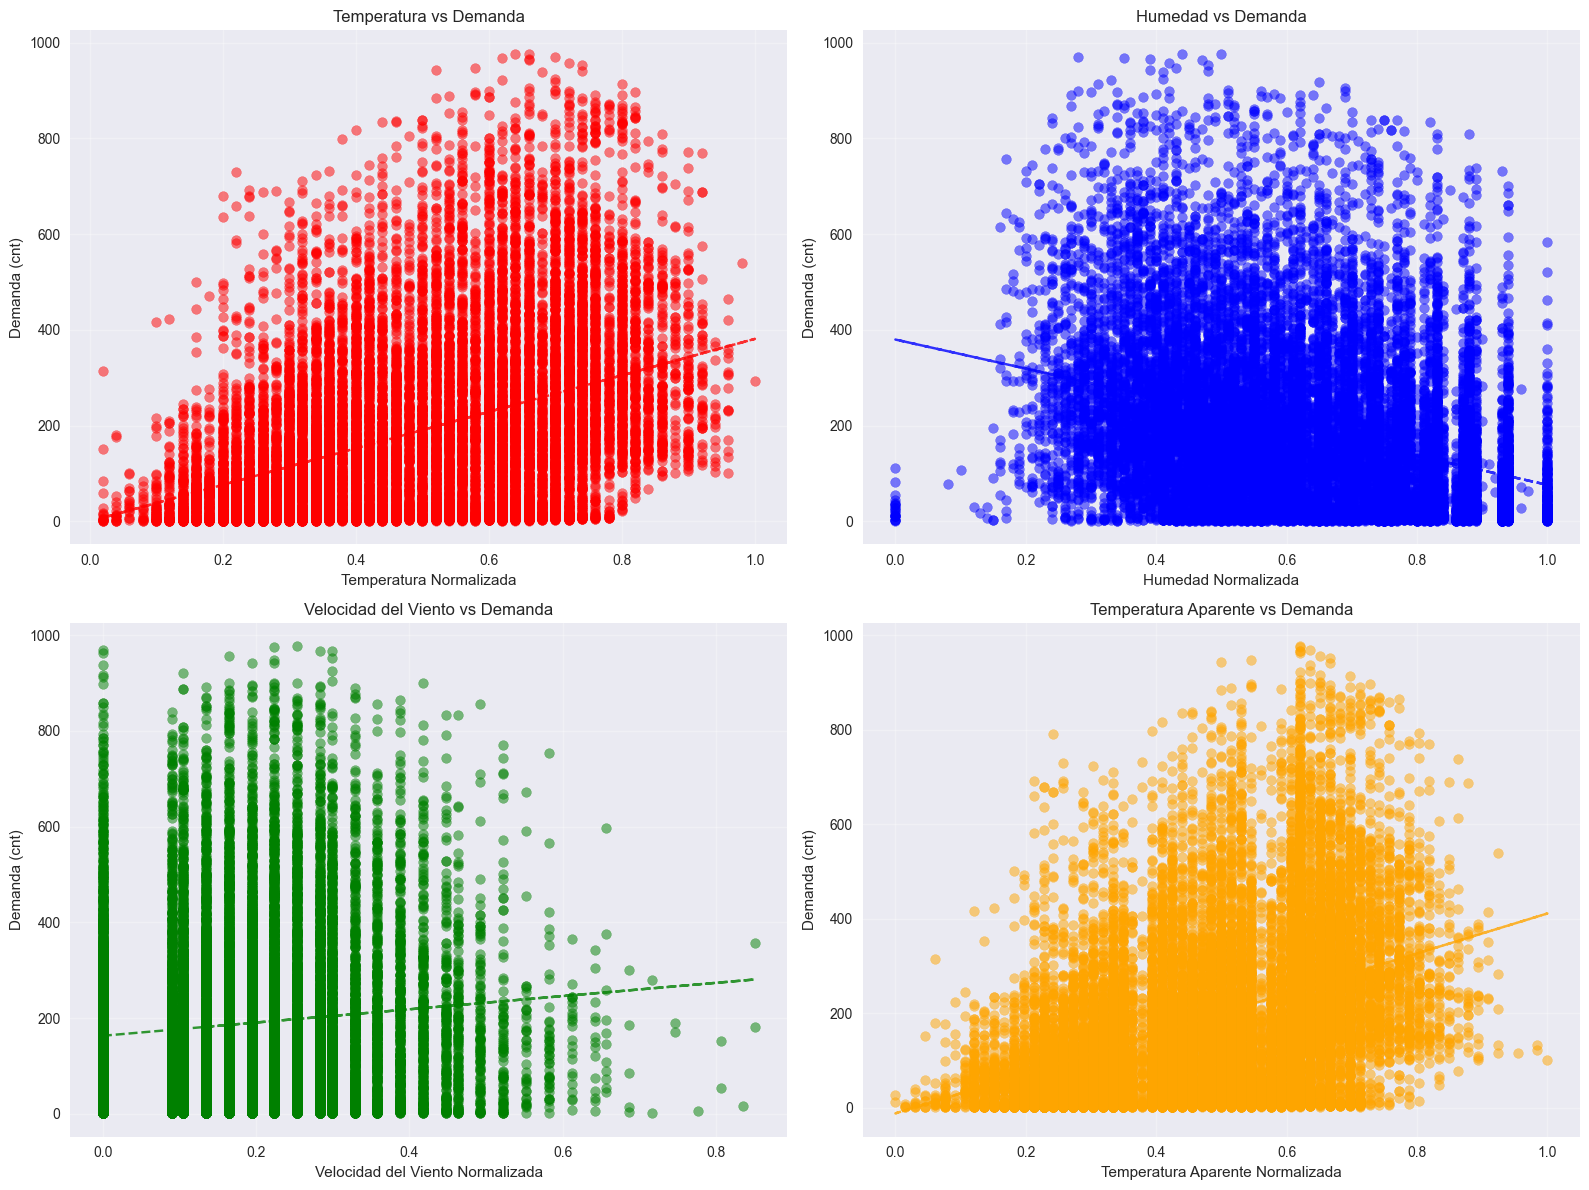


📊 ANÁLISIS CUANTITATIVO DE RELACIONES CLIMÁTICAS:
• Correlación Temperatura-Demanda: 0.405
• Correlación Humedad-Demanda: -0.323
• Correlación Viento-Demanda: 0.093
• Correlación Temp.Aparente-Demanda: 0.401

🌡️ ANÁLISIS POR RANGOS DE TEMPERATURA:
• Temperatura Baja: 73.9 bicicletas/hora (n=2572.0)
• Temperatura Media-Baja: 153.7 bicicletas/hora (n=6288.0)
• Temperatura Media-Alta: 231.7 bicicletas/hora (n=6920.0)
• Temperatura Alta: 333.2 bicicletas/hora (n=1599.0)

💧 ANÁLISIS POR RANGOS DE HUMEDAD:
• Humedad Baja: 276.1 bicicletas/hora (n=309.0)
• Humedad Media-Baja: 257.5 bicicletas/hora (n=4853.0)
• Humedad Media-Alta: 192.2 bicicletas/hora (n=7022.0)
• Humedad Alta: 117.1 bicicletas/hora (n=5195.0)


In [21]:
# 1.9 Análisis de relaciones entre variables climáticas y demanda
print("🌡️ ANÁLISIS DE RELACIONES CLIMÁTICAS VS DEMANDA")
print("=" * 50)

# Crear gráficos de dispersión para variables climáticas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Temperatura vs Demanda
axes[0, 0].scatter(df['temp'], df['cnt'], alpha=0.5, color='red')
axes[0, 0].set_title('Temperatura vs Demanda')
axes[0, 0].set_xlabel('Temperatura Normalizada')
axes[0, 0].set_ylabel('Demanda (cnt)')
axes[0, 0].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['temp'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['temp'], p(df['temp']), "r--", alpha=0.8)

# 2. Humedad vs Demanda
axes[0, 1].scatter(df['hum'], df['cnt'], alpha=0.5, color='blue')
axes[0, 1].set_title('Humedad vs Demanda')
axes[0, 1].set_xlabel('Humedad Normalizada')
axes[0, 1].set_ylabel('Demanda (cnt)')
axes[0, 1].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['hum'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['hum'], p(df['hum']), "b--", alpha=0.8)

# 3. Velocidad del viento vs Demanda
axes[1, 0].scatter(df['windspeed'], df['cnt'], alpha=0.5, color='green')
axes[1, 0].set_title('Velocidad del Viento vs Demanda')
axes[1, 0].set_xlabel('Velocidad del Viento Normalizada')
axes[1, 0].set_ylabel('Demanda (cnt)')
axes[1, 0].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['windspeed'], df['cnt'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['windspeed'], p(df['windspeed']), "g--", alpha=0.8)

# 4. Temperatura aparente vs Demanda
axes[1, 1].scatter(df['atemp'], df['cnt'], alpha=0.5, color='orange')
axes[1, 1].set_title('Temperatura Aparente vs Demanda')
axes[1, 1].set_xlabel('Temperatura Aparente Normalizada')
axes[1, 1].set_ylabel('Demanda (cnt)')
axes[1, 1].grid(True, alpha=0.3)

# Agregar línea de tendencia
z = np.polyfit(df['atemp'], df['cnt'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['atemp'], p(df['atemp']), "orange", linestyle="--", alpha=0.8)

plt.tight_layout()
plt.show()

# Análisis cuantitativo de las relaciones
print("\n📊 ANÁLISIS CUANTITATIVO DE RELACIONES CLIMÁTICAS:")
print(f"• Correlación Temperatura-Demanda: {df['temp'].corr(df['cnt']):.3f}")
print(f"• Correlación Humedad-Demanda: {df['hum'].corr(df['cnt']):.3f}")
print(f"• Correlación Viento-Demanda: {df['windspeed'].corr(df['cnt']):.3f}")
print(f"• Correlación Temp.Aparente-Demanda: {df['atemp'].corr(df['cnt']):.3f}")

# Análisis por rangos de temperatura
print("\n🌡️ ANÁLISIS POR RANGOS DE TEMPERATURA:")
df['temp_range'] = pd.cut(df['temp'], bins=4, labels=['Baja', 'Media-Baja', 'Media-Alta', 'Alta'])
temp_range_analysis = df.groupby('temp_range')['cnt'].agg(['mean', 'count'])
for temp_range in temp_range_analysis.index:
    stats = temp_range_analysis.loc[temp_range]
    print(f"• Temperatura {temp_range}: {stats['mean']:.1f} bicicletas/hora (n={stats['count']})")

# Análisis por rangos de humedad
print("\n💧 ANÁLISIS POR RANGOS DE HUMEDAD:")
df['hum_range'] = pd.cut(df['hum'], bins=4, labels=['Baja', 'Media-Baja', 'Media-Alta', 'Alta'])
hum_range_analysis = df.groupby('hum_range')['cnt'].agg(['mean', 'count'])
for hum_range in hum_range_analysis.index:
    stats = hum_range_analysis.loc[hum_range]
    print(f"• Humedad {hum_range}: {stats['mean']:.1f} bicicletas/hora (n={stats['count']})")

# Limpiar columnas temporales
df = df.drop(['temp_range', 'hum_range'], axis=1)

---

# Fase 2: Preprocesamiento y Tratamiento de Datos

### 2.1 Tratamiento de Multicolinealidad

In [22]:
# 2.1 Tratamiento de Multicolinealidad
print("🔗 TRATAMIENTO DE MULTICOLINEALIDAD")
print("=" * 50)

# Verificar si atemp existe antes de eliminarla
if 'atemp' in df.columns:
    df = df.drop(columns=['atemp'])
    print(f"✅ Variable 'atemp' eliminada por multicolinealidad con 'temp'")
else:
    print(f"ℹ️ Variable 'atemp' ya había sido eliminada previamente")

print(f"📊 Forma actual del dataset: {df.shape}")
print(f"🔗 Variables disponibles: {list(df.columns)}")

🔗 TRATAMIENTO DE MULTICOLINEALIDAD
✅ Variable 'atemp' eliminada por multicolinealidad con 'temp'
📊 Forma actual del dataset: (17379, 12)
🔗 Variables disponibles: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']


### 2.2 Tratamiento de Outliers

In [25]:
def cap_outliers(df, column, method='iqr'):
    """
    Aplica capping a outliers usando el método IQR
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Contar outliers antes del tratamiento
    outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    # Aplicar capping
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    # Contar outliers después del tratamiento
    outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    return outliers_before, outliers_after

In [26]:
# 2.3 Tratamiento de Outliers
print("🔧 TRATAMIENTO DE OUTLIERS")
print("=" * 50)

# Crear una copia del dataset original para comparación
df_original = df.copy()

# Decisión de tratamiento basada en el análisis
print("📋 ESTRATEGIA DE TRATAMIENTO:")

# 1. Humedad: Solo 22 outliers (0.13%) - aplicar capping
if 'hum' in df.columns:
    before, after = cap_outliers(df, 'hum')
    print(f"✅ Humedad: {before} → {after} outliers (aplicado capping)")

# 2. Windspeed: 342 outliers (1.97%) - aplicar capping
if 'windspeed' in df.columns:
    before, after = cap_outliers(df, 'windspeed')
    print(f"✅ Velocidad del viento: {before} → {after} outliers (aplicado capping)")

# 3. Variable objetivo (cnt): NO tratar outliers ya que son valores reales de demanda
print(f"ℹ️ Variable objetivo (cnt): Outliers conservados (son valores reales de demanda alta)")

# 4. Temperatura: Sin outliers
print(f"ℹ️ Temperatura: Sin outliers detectados")

print(f"\n📊 Forma del dataset después del tratamiento: {df.shape}")

# Comparar estadísticas antes y después
print("\n📈 COMPARACIÓN ANTES/DESPUÉS DEL TRATAMIENTO:")
for col in ['hum', 'windspeed']:
    if col in df.columns:
        print(f"\n{col.upper()}:")
        print(f"  Antes  - Min: {df_original[col].min():.3f}, Max: {df_original[col].max():.3f}")
        print(f"  Después - Min: {df[col].min():.3f}, Max: {df[col].max():.3f}")

🔧 TRATAMIENTO DE OUTLIERS
📋 ESTRATEGIA DE TRATAMIENTO:
✅ Humedad: 22 → 0 outliers (aplicado capping)
✅ Velocidad del viento: 342 → 0 outliers (aplicado capping)
ℹ️ Variable objetivo (cnt): Outliers conservados (son valores reales de demanda alta)
ℹ️ Temperatura: Sin outliers detectados

📊 Forma del dataset después del tratamiento: (17379, 12)

📈 COMPARACIÓN ANTES/DESPUÉS DEL TRATAMIENTO:

HUM:
  Antes  - Min: 0.000, Max: 1.000
  Después - Min: 0.030, Max: 1.000

WINDSPEED:
  Antes  - Min: 0.000, Max: 0.851
  Después - Min: 0.000, Max: 0.477


### 2.3 Feature Engineering (Features Cíclicos)

In [27]:
# 2.4 Ingeniería de Características
print("🔧 INGENIERÍA DE CARACTERÍSTICAS")
print("=" * 50)

# Crear una copia para trabajar con características
df_features = df.copy()

print("📝 CREANDO NUEVAS CARACTERÍSTICAS:")

# 1. Características temporales cíclicas
print("\n🕐 Características temporales cíclicas:")

# Hora del día como característica cíclica
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hr'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hr'] / 24)
print("✅ hour_sin, hour_cos - Representación cíclica de la hora")

# Mes como característica cíclica
df_features['month_sin'] = np.sin(2 * np.pi * df_features['mnth'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['mnth'] / 12)
print("✅ month_sin, month_cos - Representación cíclica del mes")

# Día de la semana como característica cíclica
df_features['weekday_sin'] = np.sin(2 * np.pi * df_features['weekday'] / 7)
df_features['weekday_cos'] = np.cos(2 * np.pi * df_features['weekday'] / 7)
print("✅ weekday_sin, weekday_cos - Representación cíclica del día de semana")

🔧 INGENIERÍA DE CARACTERÍSTICAS
📝 CREANDO NUEVAS CARACTERÍSTICAS:

🕐 Características temporales cíclicas:
✅ hour_sin, hour_cos - Representación cíclica de la hora
✅ month_sin, month_cos - Representación cíclica del mes
✅ weekday_sin, weekday_cos - Representación cíclica del día de semana


### 2.4 Feature Engineering (Features de Interacción Clímatica)

In [28]:
# 2. Características de interacción climática
print("\n🌡️ Características de interacción climática:")

# Índice de comodidad térmica (temperatura ajustada por humedad)
df_features['thermal_comfort'] = df_features['temp'] * (1 - df_features['hum'] * 0.5)
print("✅ thermal_comfort - Índice de comodidad térmica")

# Interacción temperatura-velocidad del viento (sensación térmica)
df_features['wind_chill'] = df_features['temp'] * (1 - df_features['windspeed'] * 0.3)
print("✅ wind_chill - Sensación térmica ajustada por viento")


🌡️ Características de interacción climática:
✅ thermal_comfort - Índice de comodidad térmica
✅ wind_chill - Sensación térmica ajustada por viento


### 2.5 Feature Engineering (Features Categóricas Binarias)

In [29]:
# 3. Características categóricas binarias
print("\n🏷️ Características categóricas mejoradas:")

# Horas pico (rush hours)
df_features['is_rush_hour'] = ((df_features['hr'] >= 7) & (df_features['hr'] <= 9) | 
                              (df_features['hr'] >= 17) & (df_features['hr'] <= 19)).astype(int)
print("✅ is_rush_hour - Indicador de horas pico")

# Fin de semana
df_features['is_weekend'] = (df_features['weekday'].isin([0, 6])).astype(int)
print("✅ is_weekend - Indicador de fin de semana")

# Estación cálida (primavera-verano)
df_features['is_warm_season'] = (df_features['season'].isin([1, 2])).astype(int)
print("✅ is_warm_season - Indicador de estación cálida")

# Buenas condiciones climáticas
df_features['good_weather'] = (df_features['weathersit'] == 1).astype(int)
print("✅ good_weather - Indicador de buen clima")


🏷️ Características categóricas mejoradas:
✅ is_rush_hour - Indicador de horas pico
✅ is_weekend - Indicador de fin de semana
✅ is_warm_season - Indicador de estación cálida
✅ good_weather - Indicador de buen clima


### 2.6 Feature Engineering (Eliminar Redundancia)

In [30]:
df_features.drop(columns=['hr', 'mnth', 'weekday'], inplace=True)
print("ℹ️ Columnas hr, mnth, weekday eliminadas para evitar redundancia")

ℹ️ Columnas hr, mnth, weekday eliminadas para evitar redundancia


### 2.7 Comparacion de Nuevos Features

In [31]:
print(f"\n📊 Dataset original: {df.shape}")
print(f"📊 Dataset con nuevas características: {df_features.shape}")
print(f"🆕 Nuevas características añadidas: {df_features.shape[1] - df.shape[1]}")

print(f"\n🔗 Nuevas variables creadas:")
new_features = [col for col in df_features.columns if col not in df.columns]
for feature in new_features:
    print(f"  • {feature}")

# Actualizar el dataset principal
df = df_features.copy()


📊 Dataset original: (17379, 12)
📊 Dataset con nuevas características: (17379, 21)
🆕 Nuevas características añadidas: 9

🔗 Nuevas variables creadas:
  • hour_sin
  • hour_cos
  • month_sin
  • month_cos
  • weekday_sin
  • weekday_cos
  • thermal_comfort
  • wind_chill
  • is_rush_hour
  • is_weekend
  • is_warm_season
  • good_weather


### 2.8 Nuevo Analisis de Correlaciones

🔗 ANÁLISIS DE CORRELACIONES


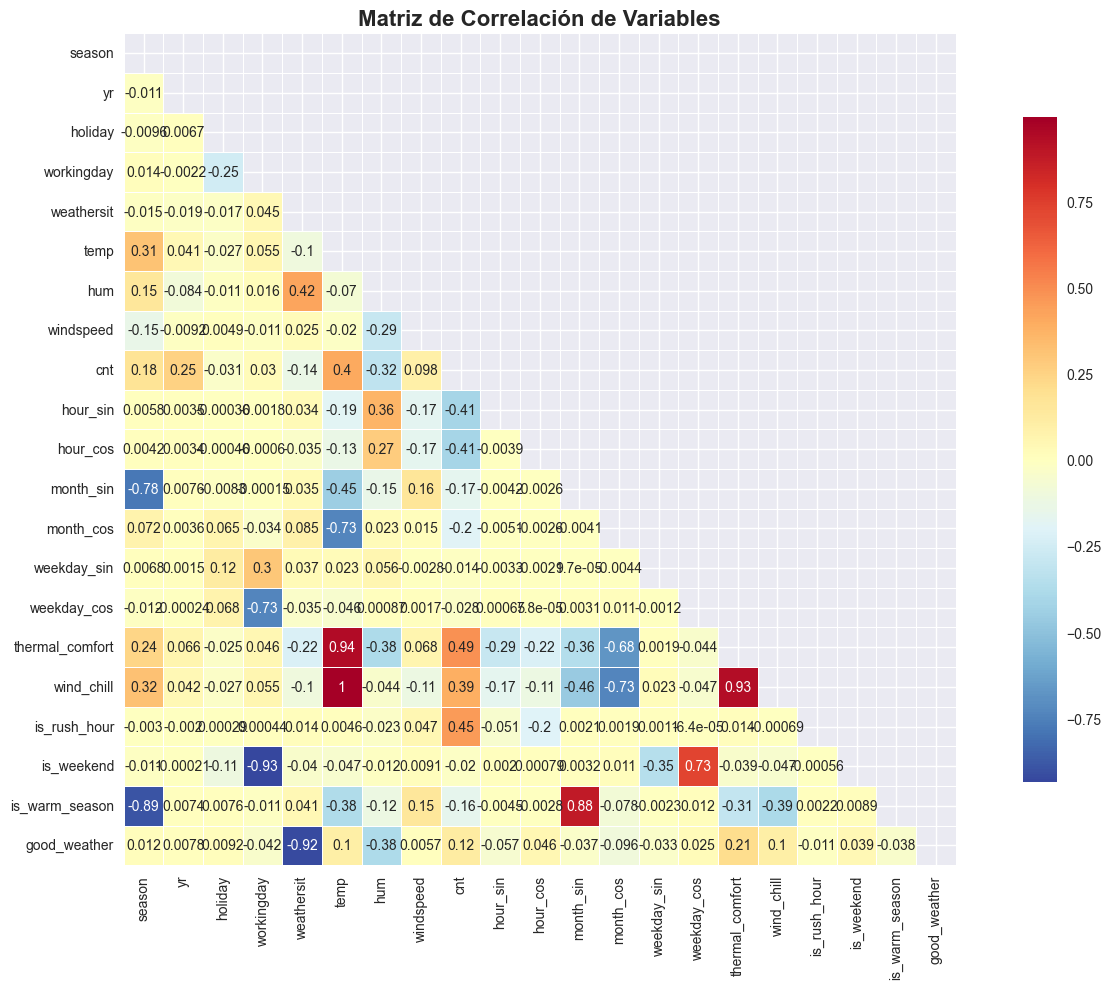


🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):
cnt                1.000000
thermal_comfort    0.487107
is_rush_hour       0.453926
hour_sin          -0.410427
hour_cos          -0.408447
temp               0.404772
wind_chill         0.390209
hum               -0.323288
yr                 0.250495
month_cos         -0.195049
season             0.178056
month_sin         -0.172969
is_warm_season    -0.158053
weathersit        -0.142426
good_weather       0.117478
windspeed          0.097983
holiday           -0.030927
workingday         0.030284
weekday_cos       -0.027610
is_weekend        -0.019699
weekday_sin       -0.013544

📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:
• thermal_comfort: 0.487 (correlación positiva)
• is_rush_hour: 0.454 (correlación positiva)
• hour_sin: -0.410 (correlación negativa)
• hour_cos: -0.408 (correlación negativa)
• temp: 0.405 (correlación positiva)

⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):
• season

In [32]:
# 2.4 Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

### 2.9 Eliminar Features Altamente Correlacionados

In [33]:
df.drop(columns=[
    'thermal_comfort', 'wind_chill',
    'is_warm_season',
    'workingday',
    'good_weather',
    'season',
    'is_weekend'
], inplace=True)
print(f"\nℹ️ Variables eliminadas por multicolinealidad o redundancia: 'thermal_comfort', 'wind_chill', 'is_warm_season', 'workingday', 'good_weather', 'season', 'is_weekend'")


ℹ️ Variables eliminadas por multicolinealidad o redundancia: 'thermal_comfort', 'wind_chill', 'is_warm_season', 'workingday', 'good_weather', 'season', 'is_weekend'


### 2.10 Analisis de Correlaciones Sin Features Redundantes

🔗 ANÁLISIS DE CORRELACIONES


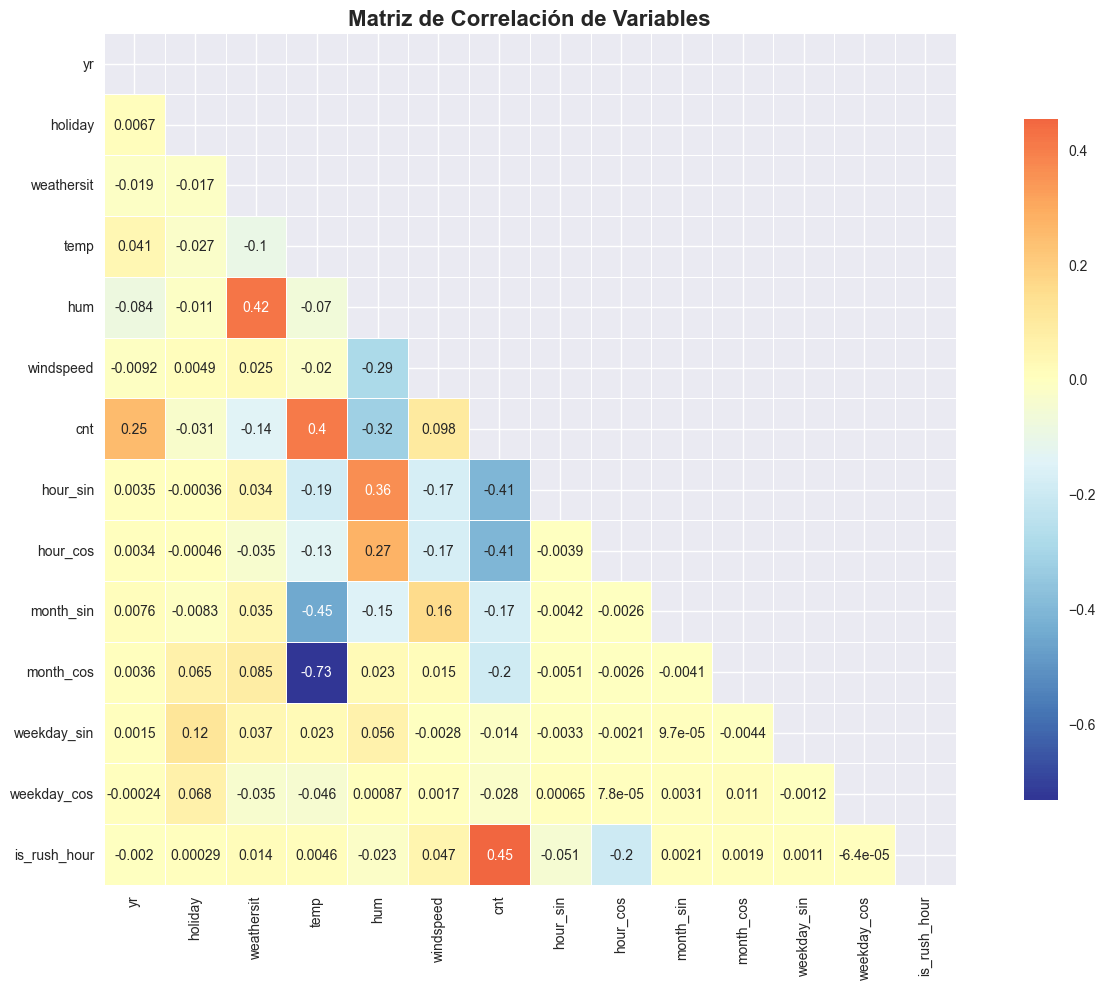


🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):
cnt             1.000000
is_rush_hour    0.453926
hour_sin       -0.410427
hour_cos       -0.408447
temp            0.404772
hum            -0.323288
yr              0.250495
month_cos      -0.195049
month_sin      -0.172969
weathersit     -0.142426
windspeed       0.097983
holiday        -0.030927
weekday_cos    -0.027610
weekday_sin    -0.013544

📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:
• is_rush_hour: 0.454 (correlación positiva)
• hour_sin: -0.410 (correlación negativa)
• hour_cos: -0.408 (correlación negativa)
• temp: 0.405 (correlación positiva)
• hum: -0.323 (correlación negativa)

⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):
• temp - month_cos: -0.734


In [34]:
# 2.4 Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

---

# Fase 3: Modelado y Evaluación

### 🎯 **ESTRATEGIA DE MODELADO**
Con el dataset optimizado, procederemos a entrenar múltiples modelos de regresión para comparar su rendimiento:

**Modelos a evaluar:**
1. **Support Vector Machine (SVM)**
2. **Decision Tree**
3. **Random Forest**
4. **XGBoost**
5. **Redes Neuronales (MLP)**
6. **Bagging**
7. **Gradient Boosting**
8. **Voting Regressor**

### 3.1 División del Dataset

In [35]:
# 3.1 División del Dataset y Preparación para Modelado
print("🔄 DIVISIÓN DEL DATASET Y PREPARACIÓN")
print("=" * 50)

# Separar características y variable objetivo
X = df.drop('cnt', axis=1)
y = df['cnt']

print(f"📊 Forma del dataset completo: {df.shape}")
print(f"🎯 Variables predictoras: {X.shape[1]}")
print(f"📈 Variable objetivo: {y.name}")

# División estratificada del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=SEED,
    shuffle=True
)

print(f"\n📊 DIVISIÓN DEL DATASET:")
print(f"  • Entrenamiento: {X_train.shape[0]} registros ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  • Prueba: {X_test.shape[0]} registros ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verificar distribuciones
print(f"\n📈 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:")
print(f"  • Entrenamiento - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  • Prueba - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

🔄 DIVISIÓN DEL DATASET Y PREPARACIÓN
📊 Forma del dataset completo: (17379, 14)
🎯 Variables predictoras: 13
📈 Variable objetivo: cnt

📊 DIVISIÓN DEL DATASET:
  • Entrenamiento: 13034 registros (75.0%)
  • Prueba: 4345 registros (25.0%)

📈 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO:
  • Entrenamiento - Media: 190.38, Std: 182.06
  • Prueba - Media: 186.71, Std: 179.35


### 3.2 Escalado de Features Continuos

In [36]:
# 1) Define cuáles son las columnas que SÍ quieres escalar
num_feats = [
    'temp', 'hum', 'windspeed'
]

print(f"\n🔧 ESCALADO DE CARACTERÍSTICAS (SOLO CONTINUA):")
scaler = StandardScaler()

# 2) Fit y transform solo en X_train[num_feats]
X_train_scaled = X_train.copy()
X_train_scaled[num_feats] = scaler.fit_transform(X_train[num_feats])

# 3) Transform en X_test[num_feats]
X_test_scaled = X_test.copy()
X_test_scaled[num_feats] = scaler.transform(X_test[num_feats])

print(f"✅ Escalado aplicado a: {num_feats}")
print(f"  • Media de features escaladas (train): {X_train_scaled[num_feats].mean().mean():.6f}")
print(f"  • Std  de features escaladas (train): {X_train_scaled[num_feats].std().mean():.6f}")

# 4) Las demás columnas (hour_sin, hour_cos, dummies, etc.) quedan intactas
print(f"\n🔗 CARACTERÍSTICAS FINALES PARA MODELADO:")
for i, feature in enumerate(X_train_scaled.columns, 1):
    print(f"{i:2d}. {feature}")

print(f"\n🚀 Datos preparados para entrenamiento de modelos!")


🔧 ESCALADO DE CARACTERÍSTICAS (SOLO CONTINUA):
✅ Escalado aplicado a: ['temp', 'hum', 'windspeed']
  • Media de features escaladas (train): 0.000000
  • Std  de features escaladas (train): 1.000038

🔗 CARACTERÍSTICAS FINALES PARA MODELADO:
 1. yr
 2. holiday
 3. weathersit
 4. temp
 5. hum
 6. windspeed
 7. hour_sin
 8. hour_cos
 9. month_sin
10. month_cos
11. weekday_sin
12. weekday_cos
13. is_rush_hour

🚀 Datos preparados para entrenamiento de modelos!


### 3.3 Verifiacion del Escalado

In [37]:
# Verificación detallada del escalado
print("🔍 VERIFICACIÓN DEL ESCALADO:")
print("=" * 50)

print("\n📊 ESTADÍSTICAS ANTES DEL ESCALADO:")
print("Variables numéricas originales:")
for feat in num_feats:
    print(f"  • {feat:15} - Media: {X_train[feat].mean():8.3f}, Std: {X_train[feat].std():8.3f}, Min: {X_train[feat].min():8.3f}, Max: {X_train[feat].max():8.3f}")

print("\n📊 ESTADÍSTICAS DESPUÉS DEL ESCALADO:")
print("Variables numéricas escaladas:")
for feat in num_feats:
    print(f"  • {feat:15} - Media: {X_train_scaled[feat].mean():8.3f}, Std: {X_train_scaled[feat].std():8.3f}, Min: {X_train_scaled[feat].min():8.3f}, Max: {X_train_scaled[feat].max():8.3f}")

print("\n📊 VARIABLES NO ESCALADAS (mantienen valores originales):")
non_scaled_features = [col for col in X_train.columns if col not in num_feats]
print(f"Total de variables no escaladas: {len(non_scaled_features)}")
for feat in non_scaled_features[:5]:  # Solo muestra 5
    col_data = X_train_scaled[feat]
    if pd.api.types.is_numeric_dtype(col_data):
        print(f"  • {feat:20} - Min: {col_data.min():6.3f}, Max: {col_data.max():6.3f}")
    else:
        print(f"  • {feat:20} - Tipo de dato no numérico ({col_data.dtype})")
if len(non_scaled_features) > 5:
    print(f"  ... y {len(non_scaled_features)-5} variables más")


print(f"\n✅ Escalado selectivo aplicado correctamente!")
print(f"   • {len(num_feats)} variables escaladas (continuas)")
print(f"   • {len(non_scaled_features)} variables sin escalar (categóricas/trigonométricas)")

🔍 VERIFICACIÓN DEL ESCALADO:

📊 ESTADÍSTICAS ANTES DEL ESCALADO:
Variables numéricas originales:
  • temp            - Media:    0.498, Std:    0.193, Min:    0.020, Max:    1.000
  • hum             - Media:    0.627, Std:    0.192, Min:    0.030, Max:    1.000
  • windspeed       - Media:    0.189, Std:    0.118, Min:    0.000, Max:    0.477

📊 ESTADÍSTICAS DESPUÉS DEL ESCALADO:
Variables numéricas escaladas:
  • temp            - Media:    0.000, Std:    1.000, Min:   -2.474, Max:    2.602
  • hum             - Media:    0.000, Std:    1.000, Min:   -3.104, Max:    1.936
  • windspeed       - Media:    0.000, Std:    1.000, Min:   -1.595, Max:    2.444

📊 VARIABLES NO ESCALADAS (mantienen valores originales):
Total de variables no escaladas: 10
  • yr                   - Min:  0.000, Max:  1.000
  • holiday              - Min:  0.000, Max:  1.000
  • weathersit           - Min:  1.000, Max:  4.000
  • hour_sin             - Min: -1.000, Max:  1.000
  • hour_cos             - Min: -1

### 3.4 Entrenamiento de Modelos Múltiples

### 🤖 **Suite de Modelos de Regresión**
Entrenaremos 8 modelos diferentes para comparar su rendimiento:

1. **🔧 Support Vector Machine (SVM)** - Modelo robusto con kernel RBF
2. **🌳 Decision Tree** - Modelo interpretable basado en árboles
3. **🌲 Random Forest** - Ensemble de árboles de decisión
4. **⚡ XGBoost** - Gradient Boosting optimizado
5. **🧠 Redes Neuronales (MLP)** - Multi-Layer Perceptron
6. **📦 Bagging** - Bootstrap Aggregating
7. **🚀 Gradient Boosting** - Boosting secuencial
8. **🗳️ Voting Regressor** - Combinación de múltiples modelos

In [38]:
# 3.3 Entrenamiento de Modelos Múltiples
print("🤖 ENTRENAMIENTO DE MODELOS MÚLTIPLES")
print("=" * 50)

import time
import xgboost as xgb

# Diccionario para almacenar los modelos entrenados
models = {}
training_times = {}
model_results = {}

# Configuraciones base para los modelos
print("🔧 Configurando modelos...")

# 1. Support Vector Machine (SVM)
print("\n1️⃣ Entrenando Support Vector Machine (SVM)...")
start_time = time.time()
svm_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
training_times['SVM'] = time.time() - start_time
models['SVM'] = svm_model
model_results['SVM'] = evaluate_regression_model(svm_model, X_test_scaled, y_test, y_pred_svm, 'SVM')
print(f"✅ SVM entrenado en {training_times['SVM']:.2f} segundos")

# 2. Decision Tree
print("\n2️⃣ Entrenando Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=SEED)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
training_times['Decision Tree'] = time.time() - start_time
models['Decision Tree'] = dt_model
model_results['Decision Tree'] = evaluate_regression_model(dt_model, X_test, y_test, y_pred_dt, 'Decision Tree')
print(f"✅ Decision Tree entrenado en {training_times['Decision Tree']:.2f} segundos")

# 3. Random Forest
print("\n3️⃣ Entrenando Random Forest...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, 
                               min_samples_leaf=5, random_state=SEED, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
training_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = rf_model
model_results['Random Forest'] = evaluate_regression_model(rf_model, X_test, y_test, y_pred_rf, 'Random Forest')
print(f"✅ Random Forest entrenado en {training_times['Random Forest']:.2f} segundos")

# 4. XGBoost
print("\n4️⃣ Entrenando XGBoost...")
start_time = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                           subsample=0.8, colsample_bytree=0.8, random_state=SEED, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
training_times['XGBoost'] = time.time() - start_time
models['XGBoost'] = xgb_model
model_results['XGBoost'] = evaluate_regression_model(xgb_model, X_test, y_test, y_pred_xgb, 'XGBoost')
print(f"✅ XGBoost entrenado en {training_times['XGBoost']:.2f} segundos")

# 5. Redes Neuronales (MLP)
print("\n5️⃣ Entrenando Redes Neuronales (MLP)...")
start_time = time.time()
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, alpha=0.01, 
                        random_state=SEED, early_stopping=True, validation_fraction=0.1)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
training_times['Neural Network'] = time.time() - start_time
models['Neural Network'] = mlp_model
model_results['Neural Network'] = evaluate_regression_model(mlp_model, X_test_scaled, y_test, y_pred_mlp, 'Neural Network')
print(f"✅ Neural Network entrenado en {training_times['Neural Network']:.2f} segundos")

# 6. Bagging
print("\n6️⃣ Entrenando Bagging...")
start_time = time.time()
bagging_model = BaggingRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
training_times['Bagging'] = time.time() - start_time
models['Bagging'] = bagging_model
model_results['Bagging'] = evaluate_regression_model(bagging_model, X_test, y_test, y_pred_bagging, 'Bagging')
print(f"✅ Bagging entrenado en {training_times['Bagging']:.2f} segundos")

# 7. Gradient Boosting
print("\n7️⃣ Entrenando Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                   min_samples_split=10, min_samples_leaf=5, random_state=SEED)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
training_times['Gradient Boosting'] = time.time() - start_time
models['Gradient Boosting'] = gb_model
model_results['Gradient Boosting'] = evaluate_regression_model(gb_model, X_test, y_test, y_pred_gb, 'Gradient Boosting')
print(f"✅ Gradient Boosting entrenado en {training_times['Gradient Boosting']:.2f} segundos")

# 8. Voting Regressor
print("\n8️⃣ Entrenando Voting Regressor...")
start_time = time.time()
# Usar los mejores modelos para el ensemble
voting_model = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=SEED)),
    ('xgb', xgb.XGBRegressor(n_estimators=50, max_depth=6, random_state=SEED)),
    ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=SEED))
], n_jobs=-1)
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
training_times['Voting'] = time.time() - start_time
models['Voting'] = voting_model
model_results['Voting'] = evaluate_regression_model(voting_model, X_test, y_test, y_pred_voting, 'Voting')
print(f"✅ Voting entrenado en {training_times['Voting']:.2f} segundos")

print(f"\n🎉 ¡Todos los modelos entrenados exitosamente!")
print(f"⏱️ Tiempo total de entrenamiento: {sum(training_times.values()):.2f} segundos")

🤖 ENTRENAMIENTO DE MODELOS MÚLTIPLES
🔧 Configurando modelos...

1️⃣ Entrenando Support Vector Machine (SVM)...
✅ SVM entrenado en 9.36 segundos

2️⃣ Entrenando Decision Tree...
✅ Decision Tree entrenado en 0.04 segundos

3️⃣ Entrenando Random Forest...
✅ Random Forest entrenado en 0.45 segundos

4️⃣ Entrenando XGBoost...
✅ XGBoost entrenado en 0.26 segundos

5️⃣ Entrenando Redes Neuronales (MLP)...
✅ Neural Network entrenado en 15.83 segundos

6️⃣ Entrenando Bagging...
✅ Bagging entrenado en 5.78 segundos

7️⃣ Entrenando Gradient Boosting...
✅ Gradient Boosting entrenado en 3.05 segundos

8️⃣ Entrenando Voting Regressor...
✅ Voting entrenado en 3.28 segundos

🎉 ¡Todos los modelos entrenados exitosamente!
⏱️ Tiempo total de entrenamiento: 38.05 segundos


### 3.4 Evaluación y Comparación de Modelos

In [ ]:
# 3.3 Evaluación y Comparación de Modelos
print("📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS")
print("=" * 50)

# 1. Tabla de métricas de rendimiento
print("📈 TABLA DE MÉTRICAS DE RENDIMIENTO:")
print("-" * 80)

# Crear tabla resumen de métricas
metrics_summary = []
for model_name, results in model_results.items():
    metrics_summary.append({
        'Modelo': model_name,
        'R²': results['R²'],
        'RMSE': results['RMSE'],
        'MAE': results['MAE'],
        'MAPE': results['MAPE'],
        'Tiempo (s)': training_times[model_name]
    })

# Crear DataFrame y ordenar por R²
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values('R²', ascending=False)

# Mostrar tabla formateada
print(metrics_df.to_string(index=False, float_format='%.3f'))

# 2. Identificar el mejor modelo
best_model_name = metrics_df.iloc[0]['Modelo']
best_r2 = metrics_df.iloc[0]['R²']
best_rmse = metrics_df.iloc[0]['RMSE']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • R²: {best_r2:.3f}")
print(f"   • RMSE: {best_rmse:.3f}")
print(f"   • Tiempo de entrenamiento: {training_times[best_model_name]:.2f}s")

# 3. Análisis de rendimiento
print(f"\n📊 ANÁLISIS DE RENDIMIENTO:")
print(f"   • Mejor R²: {metrics_df['R²'].max():.3f} ({metrics_df.loc[metrics_df['R²'].idxmax(), 'Modelo']})")
print(f"   • Menor RMSE: {metrics_df['RMSE'].min():.3f} ({metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Modelo']})")
print(f"   • Menor MAE: {metrics_df['MAE'].min():.3f} ({metrics_df.loc[metrics_df['MAE'].idxmin(), 'Modelo']})")
print(f"   • Mayor velocidad: {metrics_df['Tiempo (s)'].min():.2f}s ({metrics_df.loc[metrics_df['Tiempo (s)'].idxmin(), 'Modelo']})")

# 4. Categorización de modelos
print(f"\n🎯 CATEGORIZACIÓN DE MODELOS:")
high_performance = metrics_df[metrics_df['R²'] > 0.8]['Modelo'].tolist()
medium_performance = metrics_df[(metrics_df['R²'] > 0.7) & (metrics_df['R²'] <= 0.8)]['Modelo'].tolist()
low_performance = metrics_df[metrics_df['R²'] <= 0.7]['Modelo'].tolist()

print(f"   🥇 Alto rendimiento (R² > 0.8): {high_performance}")
print(f"   🥈 Rendimiento medio (0.7 < R² ≤ 0.8): {medium_performance}")
print(f"   🥉 Rendimiento bajo (R² ≤ 0.7): {low_performance}")

# 5. Recomendaciones
print(f"\n💡 RECOMENDACIONES:")
if best_r2 > 0.85:
    print(f"   ✅ Excelente rendimiento del modelo {best_model_name}")
elif best_r2 > 0.75:
    print(f"   ✅ Buen rendimiento del modelo {best_model_name}")
else:
    print(f"   ⚠️ Rendimiento mejorable del modelo {best_model_name}")

# Análisis de eficiencia
fastest_model = metrics_df.loc[metrics_df['Tiempo (s)'].idxmin(), 'Modelo']
fastest_time = metrics_df['Tiempo (s)'].min()
print(f"   ⚡ Modelo más rápido: {fastest_model} ({fastest_time:.2f}s)")

# Análisis de trade-off rendimiento vs velocidad
print(f"\n⚖️ ANÁLISIS RENDIMIENTO vs VELOCIDAD:")
for _, row in metrics_df.head(3).iterrows():
    efficiency = row['R²'] / row['Tiempo (s)']
    print(f"   • {row['Modelo']}: R²={row['R²']:.3f}, Tiempo={row['Tiempo (s)']:.2f}s, Eficiencia={efficiency:.3f}")

print(f"\n🔍 Preparando visualizaciones detalladas...")

📊 EVALUACIÓN Y COMPARACIÓN DE MODELOS
📈 TABLA DE MÉTRICAS DE RENDIMIENTO:
--------------------------------------------------------------------------------
           Modelo    R²   RMSE    MAE   MAPE  Tiempo (s)
          XGBoost 0.938 44.491 27.981 47.108       0.264
Gradient Boosting 0.938 44.591 27.944 46.790       3.046
   Neural Network 0.935 45.894 30.109 57.973      15.825
          Bagging 0.931 47.158 27.511 35.859       5.784
           Voting 0.925 49.223 31.722 53.069       3.282
    Random Forest 0.918 51.472 29.993 39.117       0.445
    Decision Tree 0.890 59.575 35.259 40.219       0.042
              SVM 0.871 64.327 39.487 49.288       9.362

🏆 MEJOR MODELO: XGBoost
   • R²: 0.938
   • RMSE: 44.491
   • Tiempo de entrenamiento: 0.26s

📊 ANÁLISIS DE RENDIMIENTO:
   • Mejor R²: 0.938 (XGBoost)
   • Menor RMSE: 44.491 (XGBoost)
   • Menor MAE: 27.511 (Bagging)
   • Mayor velocidad: 0.04s (Decision Tree)

🎯 CATEGORIZACIÓN DE MODELOS:
   🥇 Alto rendimiento (R² > 0.8): ['XG

### 3.5 Plots Comparativos de Resultados

📊 GENERANDO VISUALIZACIONES COMPARATIVAS
📈 Generando gráfico de métricas comparativas...


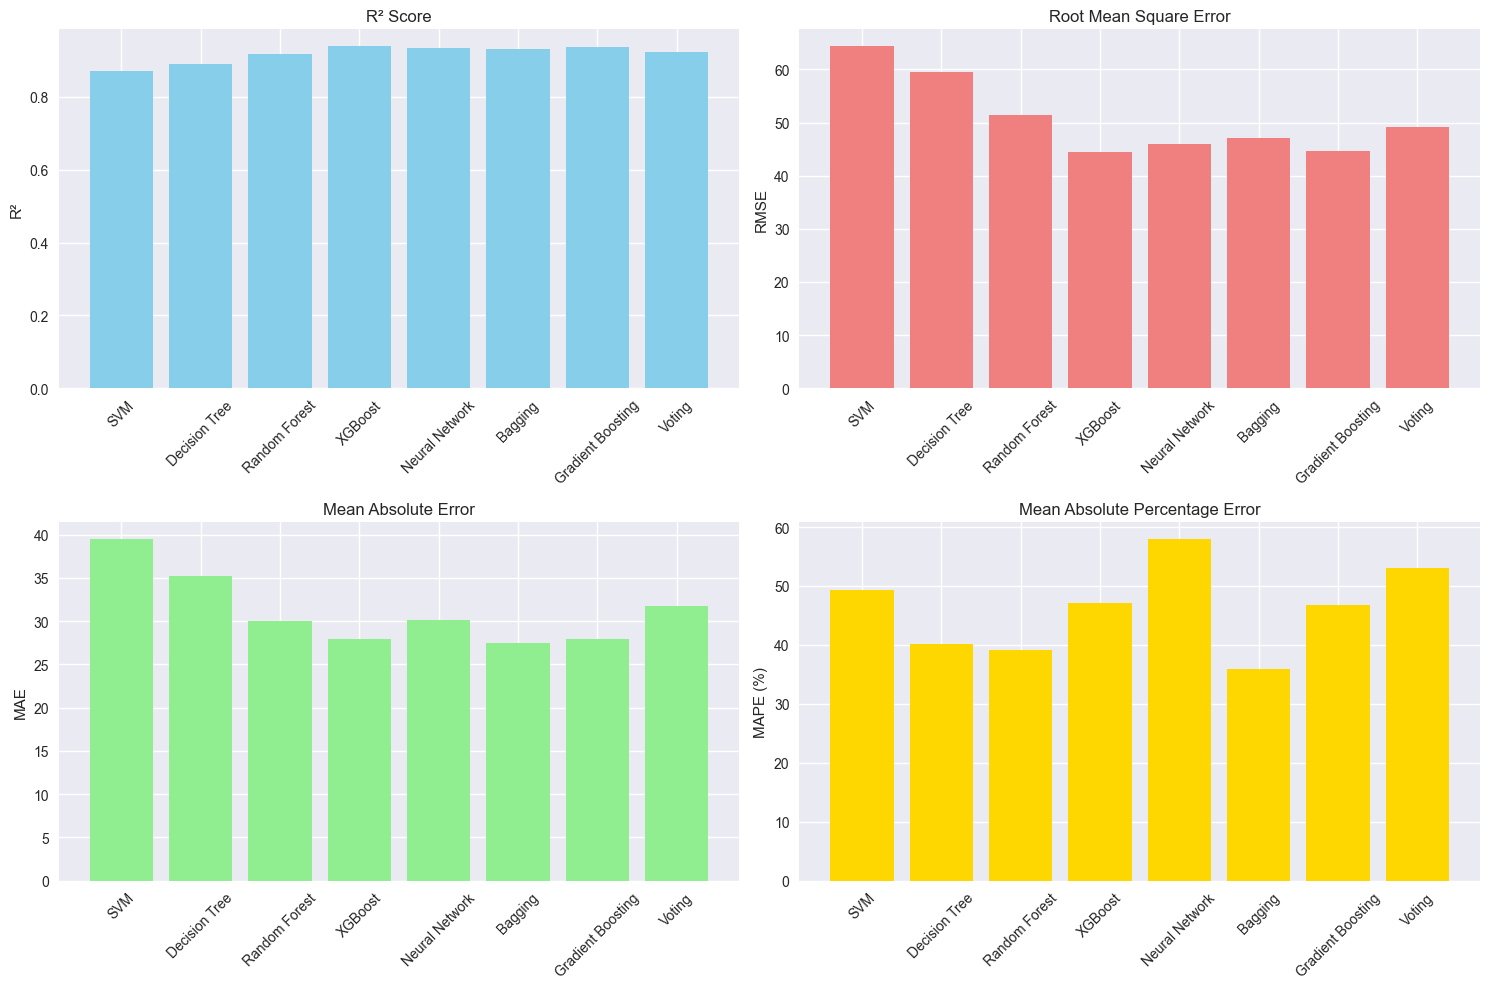

🎯 Generando gráfico de predicciones vs valores reales...


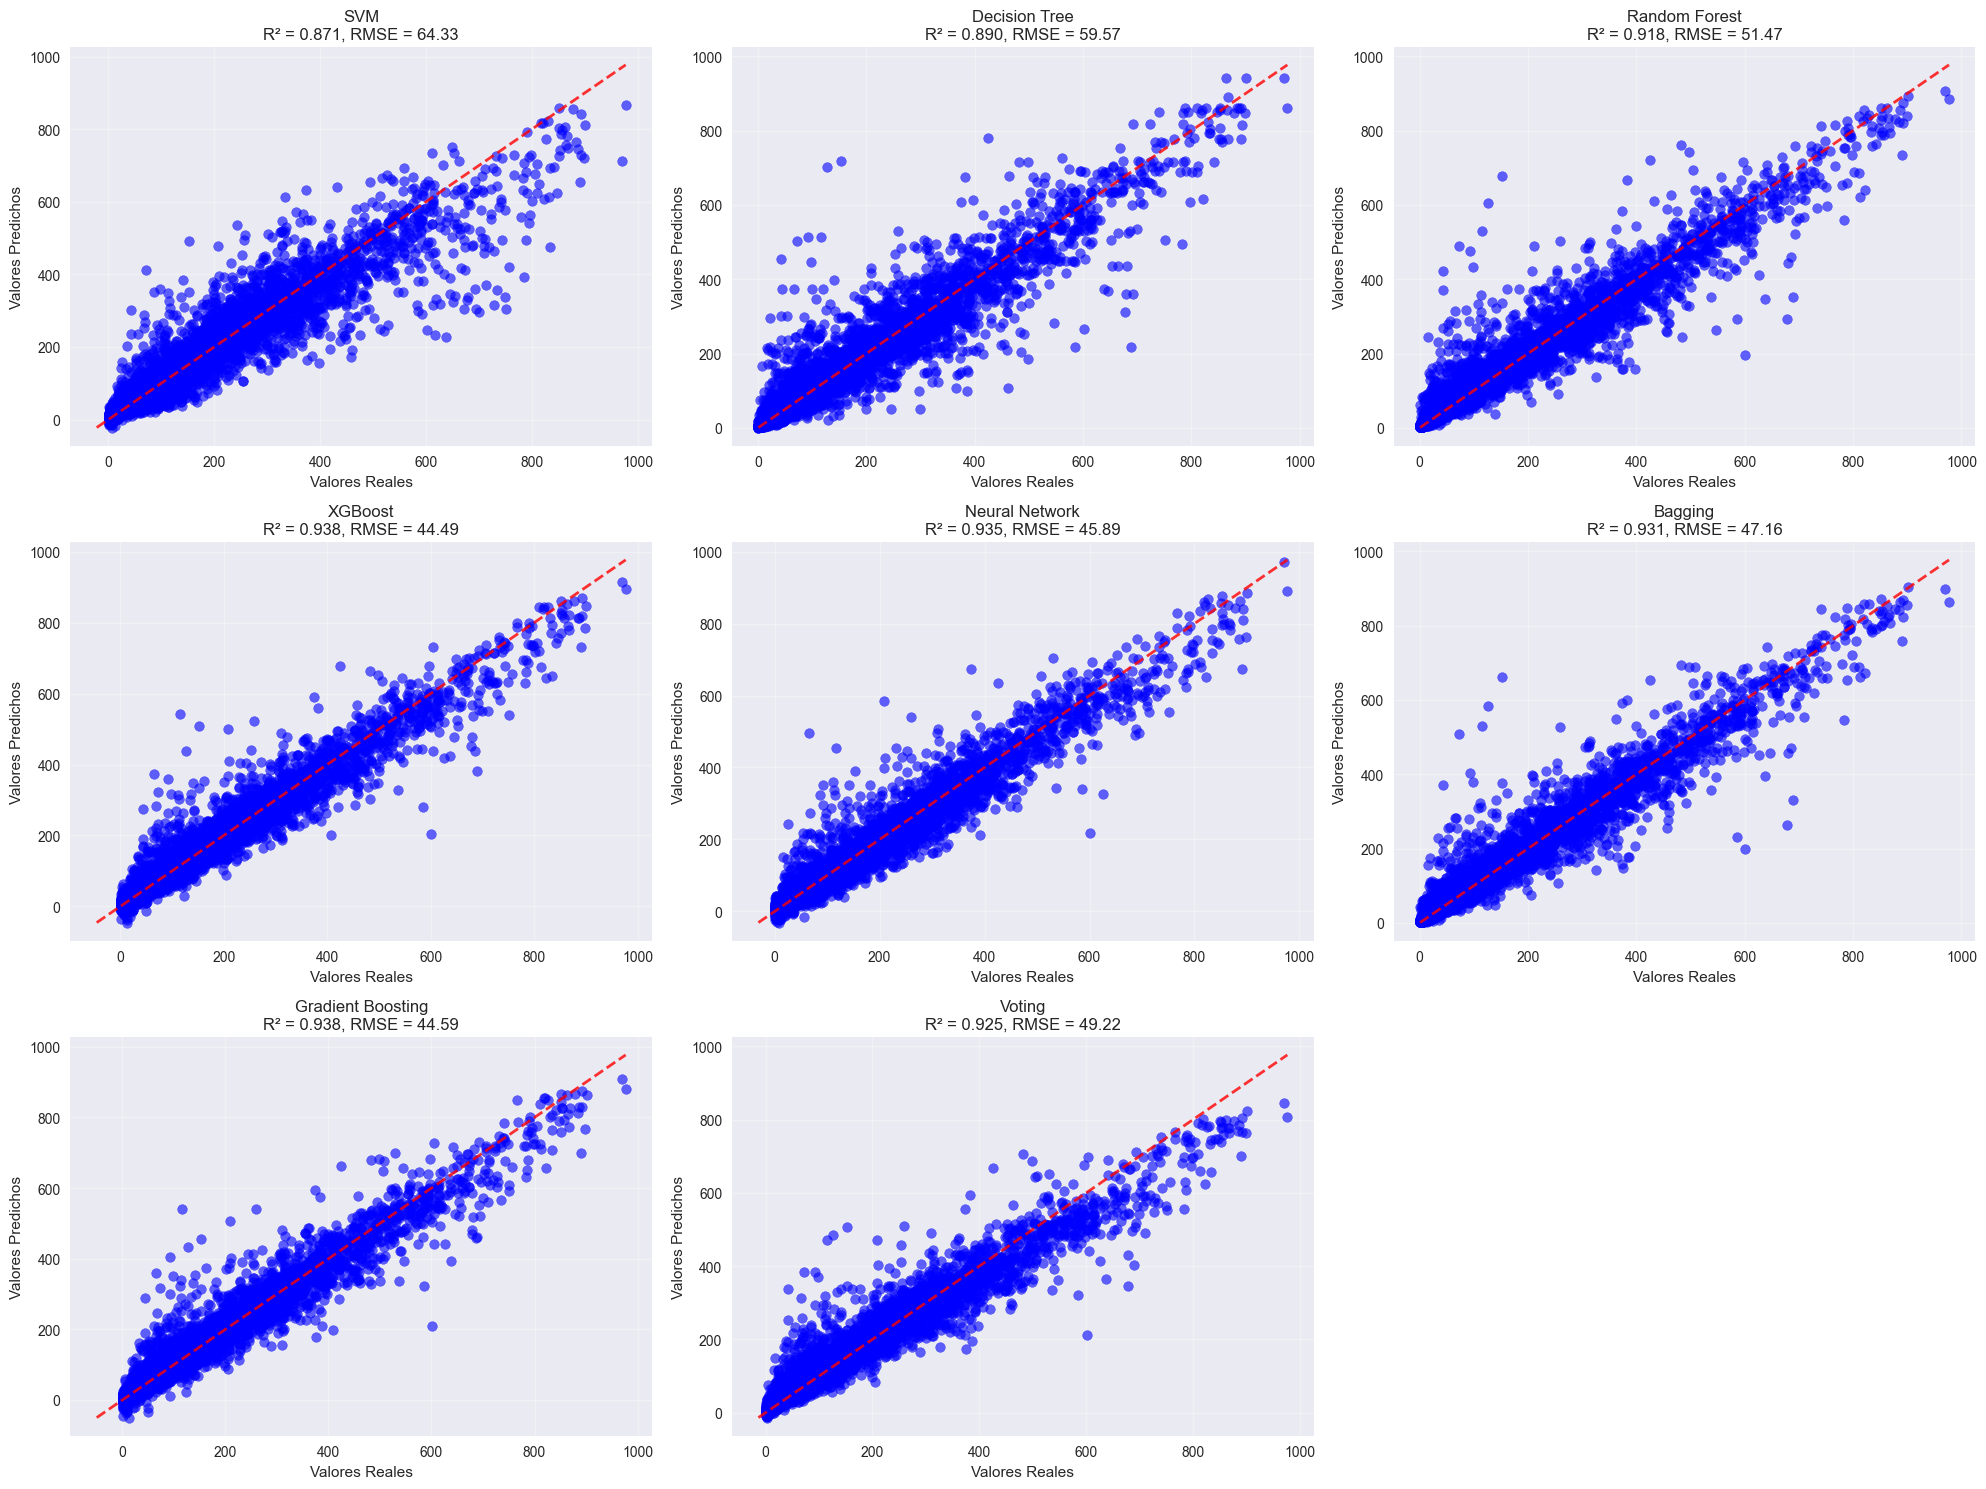

📉 Generando análisis de residuos...


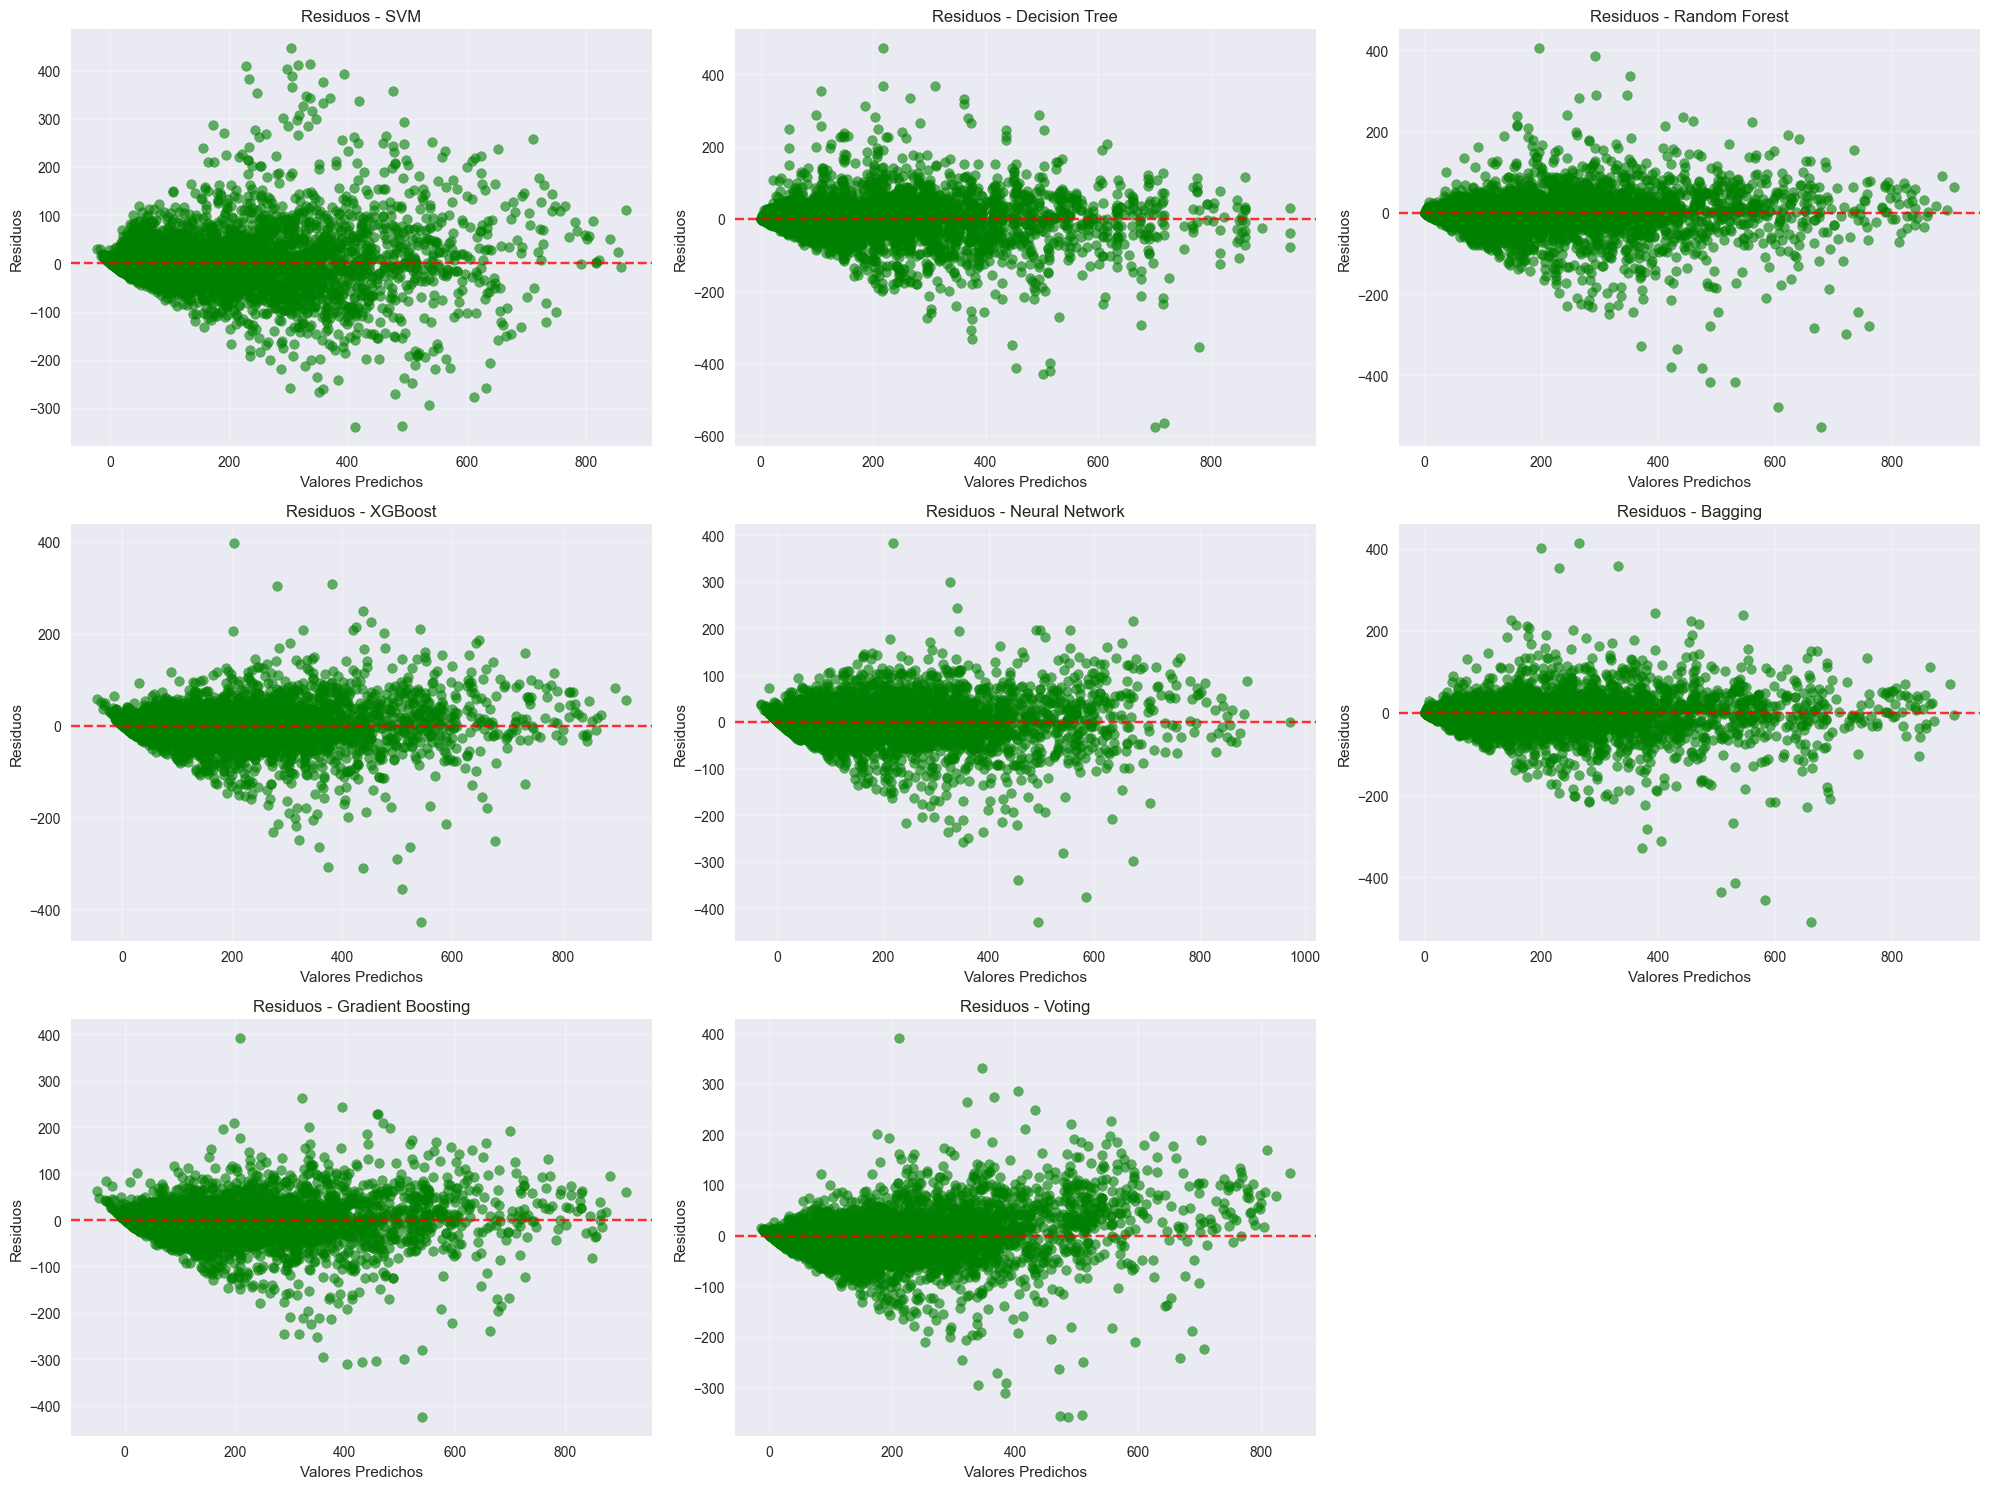

⏱️ Generando gráfico de tiempos de entrenamiento...


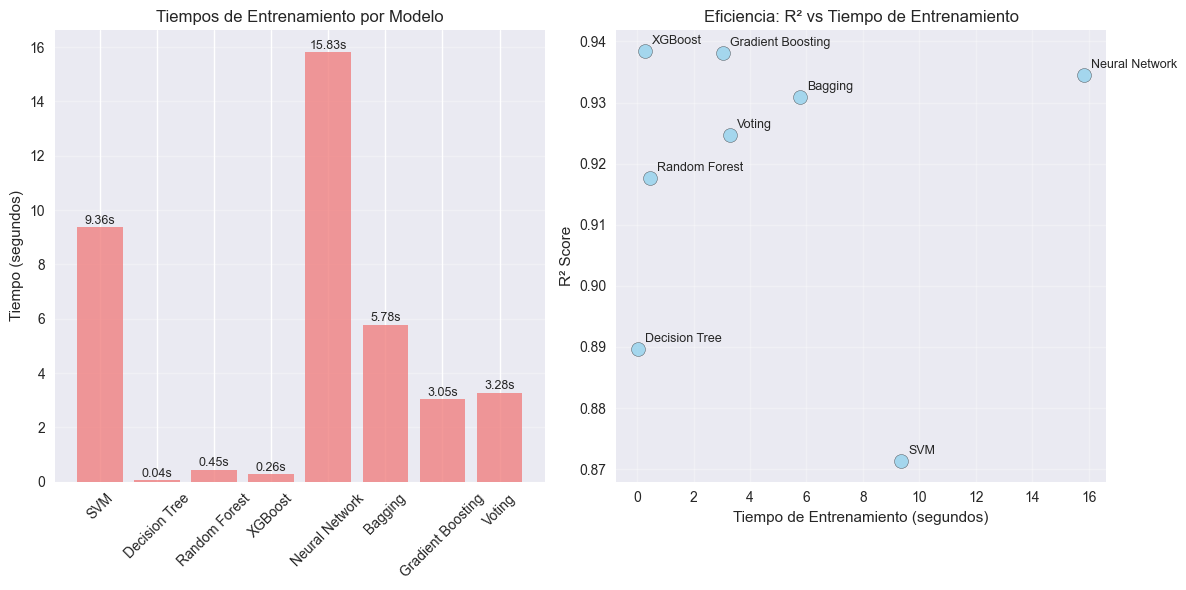


🏆 RANKING FINAL DE MODELOS:
🎖️ RANKING PONDERADO (70% Rendimiento + 30% Velocidad):
1. Decision Tree   | R²: 0.890 | RMSE: 59.57 | Tiempo: 0.04s | Score: 0.964
2. XGBoost         | R²: 0.938 | RMSE: 44.49 | Tiempo: 0.26s | Score: 0.817
3. Random Forest   | R²: 0.918 | RMSE: 51.47 | Tiempo: 0.45s | Score: 0.763
4. Gradient Boosting | R²: 0.938 | RMSE: 44.59 | Tiempo: 3.05s | Score: 0.713
5. Voting          | R²: 0.925 | RMSE: 49.22 | Tiempo: 3.28s | Score: 0.702
6. Bagging         | R²: 0.931 | RMSE: 47.16 | Tiempo: 5.78s | Score: 0.702
7. Neural Network  | R²: 0.935 | RMSE: 45.89 | Tiempo: 15.83s | Score: 0.700
8. SVM             | R²: 0.871 | RMSE: 64.33 | Tiempo: 9.36s | Score: 0.654

🥇 MODELO GANADOR: Decision Tree
   📊 R²: 0.890
   📉 RMSE: 59.57
   ⏱️ Tiempo: 0.04s
   🎯 Score ponderado: 0.964

✅ Evaluación completa terminada!


In [40]:
# 3.5 Visualizaciones Comparativas
print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("=" * 50)

# 1. Gráfico de métricas comparativas
print("📈 Generando gráfico de métricas comparativas...")
metrics_comparison_df = compare_models_metrics(model_results, figsize=(15, 10))

# 2. Gráfico de predicciones vs valores reales
print("🎯 Generando gráfico de predicciones vs valores reales...")
plot_regression_results(model_results, y_test, figsize=(20, 15))

# 3. Análisis de residuos
print("📉 Generando análisis de residuos...")
plot_residuals_analysis(model_results, y_test, figsize=(20, 15))

# 4. Gráfico de tiempos de entrenamiento
print("⏱️ Generando gráfico de tiempos de entrenamiento...")
plt.figure(figsize=(12, 6))
models_names = list(training_times.keys())
times = list(training_times.values())

plt.subplot(1, 2, 1)
bars = plt.bar(models_names, times, color='lightcoral', alpha=0.8)
plt.title('Tiempos de Entrenamiento por Modelo')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.2f}s', ha='center', va='bottom', fontsize=9)

# 5. Gráfico de eficiencia (R² vs Tiempo)
plt.subplot(1, 2, 2)
r2_scores = [model_results[model]['R²'] for model in models_names]
plt.scatter(times, r2_scores, s=100, alpha=0.7, c='skyblue', edgecolor='black')

for i, model in enumerate(models_names):
    plt.annotate(model, (times[i], r2_scores[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=9)

plt.xlabel('Tiempo de Entrenamiento (segundos)')
plt.ylabel('R² Score')
plt.title('Eficiencia: R² vs Tiempo de Entrenamiento')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Ranking final de modelos
print("\n🏆 RANKING FINAL DE MODELOS:")
print("=" * 50)

# Crear ranking ponderado (70% rendimiento, 30% velocidad)
ranking_data = []
for model_name in models_names:
    r2_score = model_results[model_name]['R²']
    time_score = 1 / (training_times[model_name] + 0.1)  # Inverso del tiempo
    
    # Normalizar scores
    r2_norm = r2_score / max(r2_scores)
    time_norm = time_score / max([1 / (t + 0.1) for t in times])
    
    # Score ponderado
    weighted_score = 0.7 * r2_norm + 0.3 * time_norm
    
    ranking_data.append({
        'Modelo': model_name,
        'R²': r2_score,
        'RMSE': model_results[model_name]['RMSE'],
        'MAE': model_results[model_name]['MAE'],
        'Tiempo': training_times[model_name],
        'Score_Ponderado': weighted_score
    })

# Ordenar por score ponderado
ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Score_Ponderado', ascending=False)

print("🎖️ RANKING PONDERADO (70% Rendimiento + 30% Velocidad):")
for i, (_, row) in enumerate(ranking_df.iterrows(), 1):
    print(f"{i}. {row['Modelo']:<15} | R²: {row['R²']:.3f} | RMSE: {row['RMSE']:.2f} | Tiempo: {row['Tiempo']:.2f}s | Score: {row['Score_Ponderado']:.3f}")

# Guardar el mejor modelo
best_model_final = ranking_df.iloc[0]['Modelo']
best_model_obj = models[best_model_final]

print(f"\n🥇 MODELO GANADOR: {best_model_final}")
print(f"   📊 R²: {ranking_df.iloc[0]['R²']:.3f}")
print(f"   📉 RMSE: {ranking_df.iloc[0]['RMSE']:.2f}")
print(f"   ⏱️ Tiempo: {ranking_df.iloc[0]['Tiempo']:.2f}s")
print(f"   🎯 Score ponderado: {ranking_df.iloc[0]['Score_Ponderado']:.3f}")

print(f"\n✅ Evaluación completa terminada!")

### 3.6 Cross Validation (Pipeline)

#### 🔧 **Implementación Correcta con Pipeline**
Para evitar **data leakage**, usaremos Pipeline que aplica el escalado dentro de cada fold del cross validation, asegurando que:

- **El escalado se ajusta solo con datos de entrenamiento** de cada fold
- **Los datos de validación se transforman** usando el scaler entrenado
- **No hay filtración de información** entre folds
- **Resultados más realistas** y confiables

In [41]:
# 3.5 Cross Validation de Todos los Modelos (Pipeline - Método Correcto)
print("🔄 CROSS VALIDATION CON PIPELINE - MÉTODO CORRECTO")
print("=" * 60)

# Importaciones necesarias para Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import time as time_module

# Configurar K-Fold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

print("📋 Configuración de Cross Validation:")
print(f"  • Método: K-Fold con Pipeline (sin data leakage)")
print(f"  • Número de folds: {k_folds}")
print(f"  • Semilla aleatoria: {SEED}")
print(f"  • Dataset completo: {X.shape[0]} registros")
print(f"  • Variables a escalar: {num_feats}")
print(f"  • Variables sin escalar: {[col for col in X.columns if col not in num_feats]}")

# Métricas a evaluar
scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Crear ColumnTransformer para escalado selectivo
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_feats),  # Escalar solo variables numéricas
        ('passthrough', 'passthrough', [col for col in X.columns if col not in num_feats])  # Dejar otras sin cambios
    ]
)

# Definir modelos con Pipeline
print(f"\n🤖 Modelos a evaluar (con Pipeline):")

pipeline_models = {
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', 'passthrough'),  # Decision Tree no necesita escalado
        ('model', DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=SEED))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', 'passthrough'),  # Random Forest no necesita escalado
        ('model', RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, 
                                      min_samples_leaf=5, random_state=SEED, n_jobs=-1))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', 'passthrough'),  # XGBoost no necesita escalado
        ('model', xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                                 subsample=0.8, colsample_bytree=0.8, random_state=SEED, n_jobs=-1))
    ]),
    'Neural Network': Pipeline([
        ('preprocessor', preprocessor),  # Neural Network necesita escalado
        ('model', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, alpha=0.01, 
                             random_state=SEED, early_stopping=True, validation_fraction=0.1))
    ]),
    'Bagging': Pipeline([
        ('preprocessor', 'passthrough'),  # Bagging no necesita escalado
        ('model', BaggingRegressor(n_estimators=100, random_state=SEED, n_jobs=-1))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', 'passthrough'),  # Gradient Boosting no necesita escalado
        ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                          min_samples_split=10, min_samples_leaf=5, random_state=SEED))
    ]),
    'Voting': Pipeline([
        ('preprocessor', 'passthrough'),  # Voting no necesita escalado (modelos internos manejan escalado)
        ('model', VotingRegressor([
            ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=SEED)),
            ('xgb', xgb.XGBRegressor(n_estimators=50, max_depth=6, random_state=SEED)),
            ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=SEED))
        ], n_jobs=-1))
    ])
}

for i, model_name in enumerate(pipeline_models.keys(), 1):
    print(f"  {i}. {model_name}")

# Usar dataset original completo (sin escalado previo - Pipeline maneja el escalado)
X_cv_clean = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_cv_clean = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

print(f"\n📊 Dataset para Pipeline CV:")
print(f"  • Tamaño: {X_cv_clean.shape[0]} registros, {X_cv_clean.shape[1]} features")
print(f"  • Sin escalado previo - Pipeline aplicará escalado dentro de cada fold")
print(f"  ✅ Garantiza NO DATA LEAKAGE")

# Almacenar resultados
cv_results = {}  # Renombramos para que sea la variable principal
cv_times = {}

print(f"\n🚀 Iniciando Cross Validation con Pipeline...")
print("=" * 60)

# Realizar cross validation con Pipeline
for model_name, pipeline in pipeline_models.items():
    print(f"\n🔄 Cross Validation - {model_name}")
    print("-" * 40)
    
    start_time_cv = time_module.time()
    
    try:
        # Cross validation con Pipeline (evita data leakage automáticamente)
        cv_scores = cross_validate(
            pipeline, X_cv_clean, y_cv_clean,
            cv=kfold,
            scoring=scoring_metrics,
            return_train_score=True,
            n_jobs=-1
        )
        
        # Calcular métricas
        r2_scores = cv_scores['test_r2']
        rmse_scores = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
        mae_scores = -cv_scores['test_neg_mean_absolute_error']
        
        # Guardar resultados
        cv_results[model_name] = {
            'R²_scores': r2_scores,
            'RMSE_scores': rmse_scores,
            'MAE_scores': mae_scores,
            'R²_mean': np.mean(r2_scores),
            'R²_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores),
            'MAE_mean': np.mean(mae_scores),
            'MAE_std': np.std(mae_scores),
            'train_r2_mean': np.mean(cv_scores['train_r2']),
            'train_r2_std': np.std(cv_scores['train_r2'])
        }
        
        cv_times[model_name] = time_module.time() - start_time_cv
        
        # Mostrar resultados
        print(f"  ✅ Completado en {cv_times[model_name]:.2f}s")
        print(f"  📊 R² = {cv_results[model_name]['R²_mean']:.4f} ± {cv_results[model_name]['R²_std']:.4f}")
        print(f"  📊 RMSE = {cv_results[model_name]['RMSE_mean']:.2f} ± {cv_results[model_name]['RMSE_std']:.2f}")
        print(f"  📊 MAE = {cv_results[model_name]['MAE_mean']:.2f} ± {cv_results[model_name]['MAE_std']:.2f}")
        
        # Detectar overfitting
        train_test_diff = cv_results[model_name]['train_r2_mean'] - cv_results[model_name]['R²_mean']
        if train_test_diff > 0.1:
            print(f"  ⚠️  Posible overfitting detectado (diff: {train_test_diff:.3f})")
        elif train_test_diff < 0.05:
            print(f"  ✅ Buena generalización (diff: {train_test_diff:.3f})")
        else:
            print(f"  📊 Generalización moderada (diff: {train_test_diff:.3f})")
            
    except Exception as e:
        print(f"  ❌ Error en {model_name}: {str(e)}")
        cv_results[model_name] = None

print(f"\n🎉 Cross Validation completada!")
print(f"⏱️ Tiempo total: {sum(cv_times.values()):.2f} segundos")

# Mostrar resumen de resultados
print(f"\n📊 RESUMEN DE RESULTADOS DE CROSS VALIDATION (PIPELINE):")
print("=" * 70)

if cv_results:
    # Crear tabla resumen
    cv_summary = []
    for model_name, results in cv_results.items():
        if results is not None:
            cv_summary.append({
                'Modelo': model_name,
                'R² (mean ± std)': f"{results['R²_mean']:.4f} ± {results['R²_std']:.4f}",
                'RMSE (mean ± std)': f"{results['RMSE_mean']:.2f} ± {results['RMSE_std']:.2f}",
                'MAE (mean ± std)': f"{results['MAE_mean']:.2f} ± {results['MAE_std']:.2f}",
                'Tiempo (s)': f"{cv_times[model_name]:.2f}",
                'Train-Test Diff': f"{abs(results['train_r2_mean'] - results['R²_mean']):.3f}",
                'Generalización': 'Excelente' if abs(results['train_r2_mean'] - results['R²_mean']) < 0.02 else
                                'Buena' if abs(results['train_r2_mean'] - results['R²_mean']) < 0.05 else 
                                'Moderada' if abs(results['train_r2_mean'] - results['R²_mean']) < 0.1 else 'Overfitting'
            })
    
    cv_summary_df = pd.DataFrame(cv_summary)
    cv_summary_df = cv_summary_df.sort_values('R² (mean ± std)', ascending=False)
    
    print(cv_summary_df.to_string(index=False))
    
    # Mejor modelo según Pipeline CV
    best_cv_model = cv_summary_df.iloc[0]['Modelo']
    print(f"\n🏆 MEJOR MODELO SEGÚN CROSS VALIDATION (PIPELINE): {best_cv_model}")
    print(f"   📊 R² Promedio: {cv_summary_df.iloc[0]['R² (mean ± std)']}")
    print(f"   📊 RMSE Promedio: {cv_summary_df.iloc[0]['RMSE (mean ± std)']}")
    print(f"   ✅ Método sin data leakage - resultados confiables")
    
else:
    print("❌ No se pudieron obtener resultados de cross validation")

🔄 CROSS VALIDATION CON PIPELINE - MÉTODO CORRECTO
📋 Configuración de Cross Validation:
  • Método: K-Fold con Pipeline (sin data leakage)
  • Número de folds: 5
  • Semilla aleatoria: 42
  • Dataset completo: 17379 registros
  • Variables a escalar: ['temp', 'hum', 'windspeed']
  • Variables sin escalar: ['yr', 'holiday', 'weathersit', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'is_rush_hour']

🤖 Modelos a evaluar (con Pipeline):
  1. SVM
  2. Decision Tree
  3. Random Forest
  4. XGBoost
  5. Neural Network
  6. Bagging
  7. Gradient Boosting
  8. Voting

📊 Dataset para Pipeline CV:
  • Tamaño: 17379 registros, 13 features
  • Sin escalado previo - Pipeline aplicará escalado dentro de cada fold
  ✅ Garantiza NO DATA LEAKAGE

🚀 Iniciando Cross Validation con Pipeline...

🔄 Cross Validation - SVM
----------------------------------------
  ✅ Completado en 24.79s
  📊 R² = 0.8729 ± 0.0058
  📊 RMSE = 64.63 ± 1.51
  📊 MAE = 39.84 ± 0.65
  ✅ Buena generali

### 3.7 Tabla comparativa de Cross Validation

In [42]:
# Crear tabla comparativa de Cross Validation
print("\n📊 TABLA COMPARATIVA - CROSS VALIDATION RESULTS")
print("=" * 80)

# Crear DataFrame con resultados de CV
cv_summary = []
for model_name, results in cv_results.items():
    if results is not None:
        cv_summary.append({
            'Modelo': model_name,
            'R² Mean': results['R²_mean'],
            'R² Std': results['R²_std'],
            'RMSE Mean': results['RMSE_mean'],
            'RMSE Std': results['RMSE_std'],
            'MAE Mean': results['MAE_mean'],
            'MAE Std': results['MAE_std'],
            'Train R²': results['train_r2_mean'],
            'Overfitting': results['train_r2_mean'] - results['R²_mean'],
            'CV Time (s)': cv_times[model_name]
        })

cv_df = pd.DataFrame(cv_summary)
cv_df = cv_df.sort_values('R² Mean', ascending=False)

# Mostrar tabla
print(cv_df.round(4).to_string(index=False))

# Identificar el mejor modelo según CV
best_cv_model = cv_df.iloc[0]
print(f"\n🏆 MEJOR MODELO SEGÚN CROSS VALIDATION:")
print(f"  🥇 Modelo: {best_cv_model['Modelo']}")
print(f"  📊 R² Promedio: {best_cv_model['R² Mean']:.4f} ± {best_cv_model['R² Std']:.4f}")
print(f"  📊 RMSE Promedio: {best_cv_model['RMSE Mean']:.2f} ± {best_cv_model['RMSE Std']:.2f}")
print(f"  📊 Estabilidad: {'Alta' if best_cv_model['R² Std'] < 0.02 else 'Moderada' if best_cv_model['R² Std'] < 0.05 else 'Baja'}")
print(f"  📊 Overfitting: {'Bajo' if best_cv_model['Overfitting'] < 0.05 else 'Moderado' if best_cv_model['Overfitting'] < 0.1 else 'Alto'}")

# Análisis de estabilidad
print(f"\n📈 ANÁLISIS DE ESTABILIDAD:")
stable_models = cv_df[cv_df['R² Std'] < 0.03]['Modelo'].tolist()
unstable_models = cv_df[cv_df['R² Std'] >= 0.05]['Modelo'].tolist()

print(f"  ✅ Modelos Estables (R² Std < 0.03): {stable_models if stable_models else 'Ninguno'}")
print(f"  ⚠️  Modelos Inestables (R² Std >= 0.05): {unstable_models if unstable_models else 'Ninguno'}")

# Análisis de overfitting
print(f"\n🎯 ANÁLISIS DE OVERFITTING:")
good_generalization = cv_df[cv_df['Overfitting'] < 0.05]['Modelo'].tolist()
overfitting_models = cv_df[cv_df['Overfitting'] >= 0.1]['Modelo'].tolist()

print(f"  ✅ Buena Generalización (diff < 0.05): {good_generalization if good_generalization else 'Ninguno'}")
print(f"  ❌ Posible Overfitting (diff >= 0.1): {overfitting_models if overfitting_models else 'Ninguno'}")

# Ranking final considerando múltiples criterios
print(f"\n🏅 RANKING FINAL (Cross Validation):")
cv_df['Score_CV'] = (
    cv_df['R² Mean'] * 0.4 +  # 40% peso en R²
    (1 - cv_df['R² Std'] / cv_df['R² Std'].max()) * 0.3 +  # 30% peso en estabilidad
    (1 - cv_df['Overfitting'] / cv_df['Overfitting'].max()) * 0.3  # 30% peso anti-overfitting
)

cv_df_ranked = cv_df.sort_values('Score_CV', ascending=False)

for i, (_, row) in enumerate(cv_df_ranked.head().iterrows(), 1):
    print(f"  {i}. {row['Modelo']} - Score: {row['Score_CV']:.3f}")
    print(f"     R²: {row['R² Mean']:.4f}±{row['R² Std']:.4f}, RMSE: {row['RMSE Mean']:.2f}±{row['RMSE Std']:.2f}")


📊 TABLA COMPARATIVA - CROSS VALIDATION RESULTS
           Modelo  R² Mean  R² Std  RMSE Mean  RMSE Std  MAE Mean  MAE Std  Train R²  Overfitting  CV Time (s)
Gradient Boosting   0.9403  0.0045    44.2747    1.4925   28.1208   0.7877    0.9593       0.0190       2.4349
          XGBoost   0.9396  0.0034    44.5608    1.1172   28.2784   0.5266    0.9574       0.0178       0.7435
          Bagging   0.9344  0.0040    46.4246    1.3743   27.6920   0.7419    0.9908       0.0564       3.5650
   Neural Network   0.9333  0.0043    46.7930    1.2794   30.8873   0.7444    0.9457       0.0123      19.4714
           Voting   0.9253  0.0040    49.5397    1.3040   32.2464   0.7944    0.9547       0.0293       2.6657
    Random Forest   0.9218  0.0060    50.6772    1.9343   30.0895   0.9539    0.9559       0.0341       2.0794
    Decision Tree   0.8922  0.0101    59.4596    2.5431   35.1005   1.1690    0.9539       0.0617       0.2120
              SVM   0.8729  0.0058    64.6340    1.5074   39.840

### 3.8 Plots Cross Validation


📊 VISUALIZACIONES DE CROSS VALIDATION


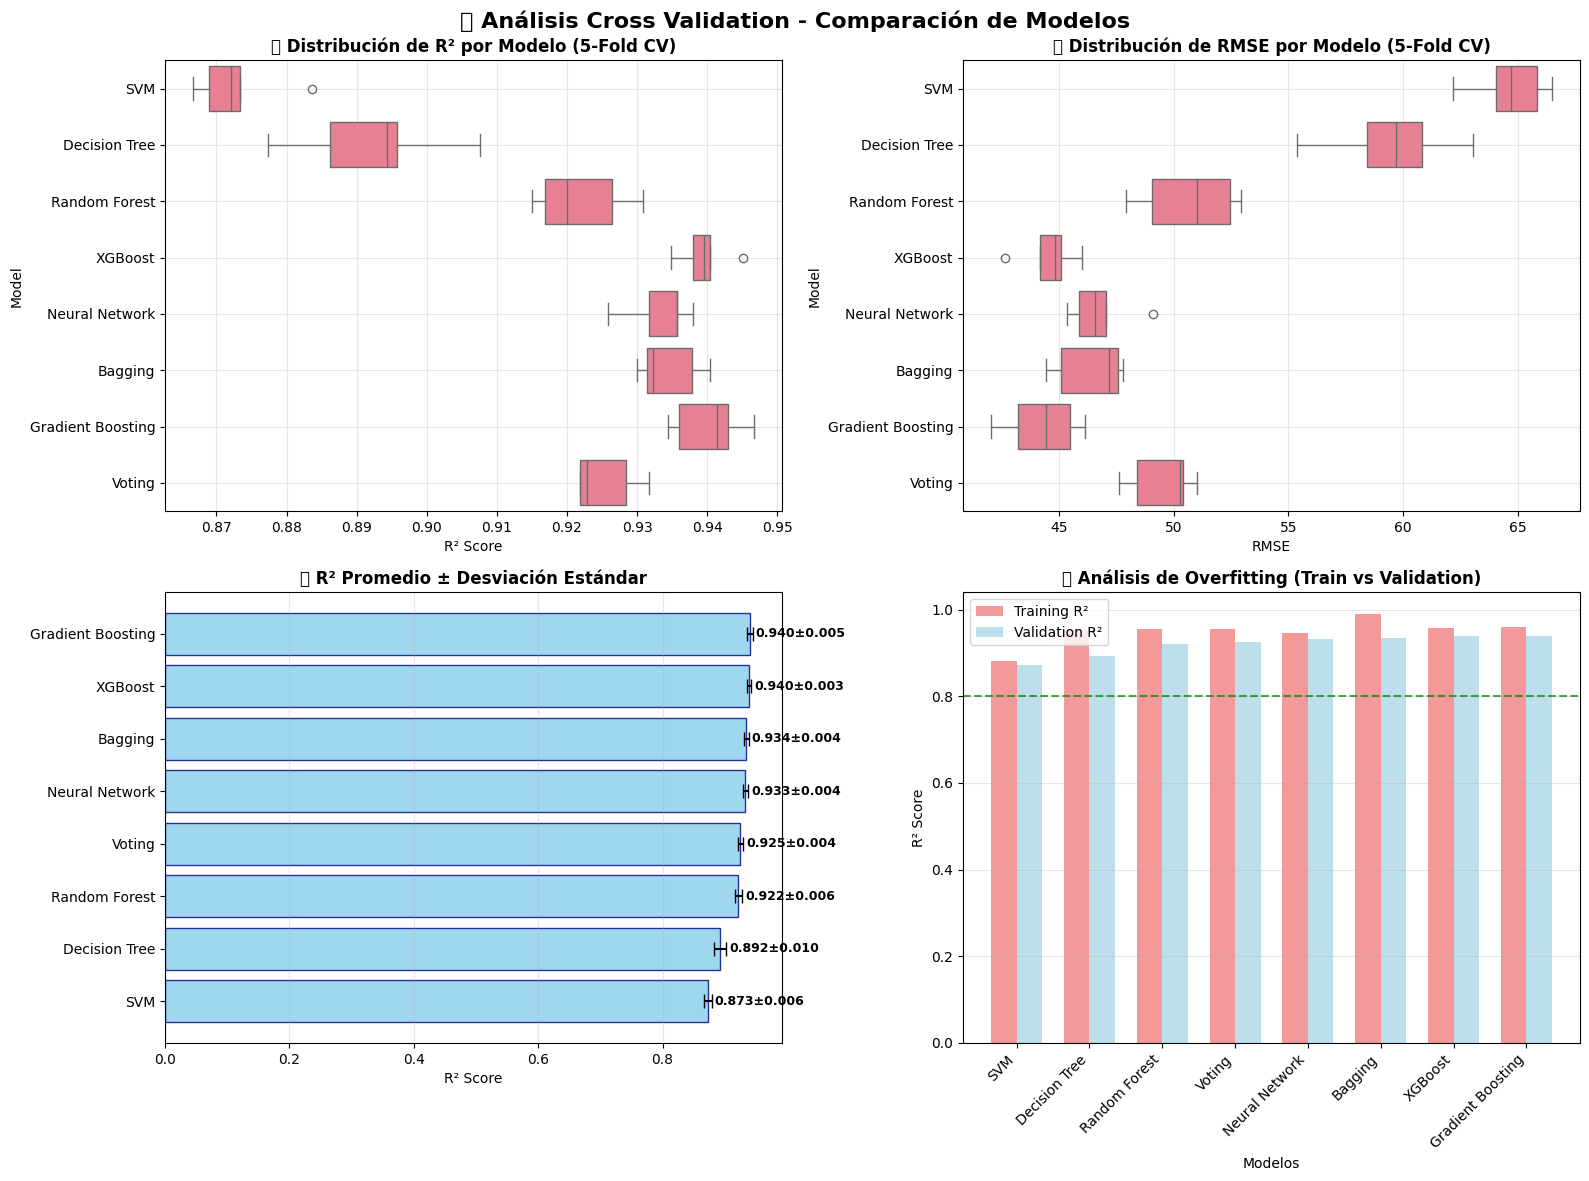


📈 ESTADÍSTICAS ADICIONALES:
  📊 Mejor R² promedio: 0.9403 (Gradient Boosting)
  📊 Menor RMSE promedio: 44.27 (Gradient Boosting)
  📊 Mayor estabilidad: XGBoost (R² Std: 0.0034)
  📊 Menor overfitting: SVM (diff: 0.0086)

✅ Cross Validation completado exitosamente!


In [43]:
# Visualizaciones de Cross Validation
print("\n📊 VISUALIZACIONES DE CROSS VALIDATION")
print("=" * 50)

# Configurar el estilo de las gráficas
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Análisis Cross Validation - Comparación de Modelos', fontsize=16, fontweight='bold')

# 1. Box plot de R² scores
ax1 = axes[0, 0]
r2_data = []
model_names = []
for model_name, results in cv_results.items():
    if results is not None:
        r2_data.extend(results['R²_scores'])
        model_names.extend([model_name] * len(results['R²_scores']))

cv_viz_df = pd.DataFrame({'Model': model_names, 'R²': r2_data})
sns.boxplot(data=cv_viz_df, y='Model', x='R²', ax=ax1)
ax1.set_title('📊 Distribución de R² por Modelo (5-Fold CV)', fontweight='bold')
ax1.set_xlabel('R² Score')
ax1.grid(True, alpha=0.3)

# 2. Box plot de RMSE scores
ax2 = axes[0, 1]
rmse_data = []
model_names = []
for model_name, results in cv_results.items():
    if results is not None:
        rmse_data.extend(results['RMSE_scores'])
        model_names.extend([model_name] * len(results['RMSE_scores']))

rmse_viz_df = pd.DataFrame({'Model': model_names, 'RMSE': rmse_data})
sns.boxplot(data=rmse_viz_df, y='Model', x='RMSE', ax=ax2)
ax2.set_title('📊 Distribución de RMSE por Modelo (5-Fold CV)', fontweight='bold')
ax2.set_xlabel('RMSE')
ax2.grid(True, alpha=0.3)

# 3. Gráfico de barras con intervalos de confianza - R²
ax3 = axes[1, 0]
models_sorted = cv_df.sort_values('R² Mean', ascending=True)
y_pos = np.arange(len(models_sorted))

bars = ax3.barh(y_pos, models_sorted['R² Mean'], 
                xerr=models_sorted['R² Std'], 
                capsize=5, alpha=0.8, color='skyblue', edgecolor='navy')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(models_sorted['Modelo'])
ax3.set_xlabel('R² Score')
ax3.set_title('📈 R² Promedio ± Desviación Estándar', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, value, std) in enumerate(zip(bars, models_sorted['R² Mean'], models_sorted['R² Std'])):
    ax3.text(value + std + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}±{std:.3f}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# 4. Análisis de Overfitting
ax4 = axes[1, 1]
train_r2 = [cv_results[model]['train_r2_mean'] for model in models_sorted['Modelo'] if cv_results[model] is not None]
test_r2 = models_sorted['R² Mean'].values

x_pos = np.arange(len(models_sorted))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, train_r2, width, label='Training R²', alpha=0.8, color='lightcoral')
bars2 = ax4.bar(x_pos + width/2, test_r2, width, label='Validation R²', alpha=0.8, color='lightblue')

ax4.set_xlabel('Modelos')
ax4.set_ylabel('R² Score')
ax4.set_title('🎯 Análisis de Overfitting (Train vs Validation)', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models_sorted['Modelo'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Línea de referencia
ax4.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Target R²=0.8')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\n📈 ESTADÍSTICAS ADICIONALES:")
print(f"  📊 Mejor R² promedio: {cv_df['R² Mean'].max():.4f} ({cv_df.loc[cv_df['R² Mean'].idxmax(), 'Modelo']})")
print(f"  📊 Menor RMSE promedio: {cv_df['RMSE Mean'].min():.2f} ({cv_df.loc[cv_df['RMSE Mean'].idxmin(), 'Modelo']})")
print(f"  📊 Mayor estabilidad: {cv_df.loc[cv_df['R² Std'].idxmin(), 'Modelo']} (R² Std: {cv_df['R² Std'].min():.4f})")
print(f"  📊 Menor overfitting: {cv_df.loc[cv_df['Overfitting'].idxmin(), 'Modelo']} (diff: {cv_df['Overfitting'].min():.4f})")

print(f"\n✅ Cross Validation completado exitosamente!")

---

# Fase 4: Optimización

### 4.1 Identificación de Top 5 Modelos para Optimización

In [44]:
# 4.1 Identificación de Top 5 Modelos para Optimización
print("🏆 IDENTIFICANDO TOP 5 MODELOS PARA OPTIMIZACIÓN")
print("=" * 60)

# Verificar que tenemos resultados del CV con Pipeline
if 'cv_results' in globals() and cv_results:
    print("✅ Usando resultados del Pipeline Cross Validation (sin data leakage)")
    
    # Crear ranking basado en R² promedio
    model_ranking = []
    for model_name, results in cv_results.items():
        if results is not None:
            model_ranking.append({
                'Modelo': model_name,
                'R²_Mean': results['R²_mean'],
                'R²_Std': results['R²_std'],
                'RMSE_Mean': results['RMSE_mean'],
                'RMSE_Std': results['RMSE_std'],
                'Train_Test_Diff': abs(results['train_r2_mean'] - results['R²_mean']),
                'Estabilidad': 'Alta' if results['R²_std'] < 0.01 else 'Media' if results['R²_std'] < 0.02 else 'Baja'
            })
    
    # Ordenar por R² promedio (descendente)
    model_ranking_df = pd.DataFrame(model_ranking)
    model_ranking_df = model_ranking_df.sort_values('R²_Mean', ascending=False)
    
    # Seleccionar Top 5
    top_5_models = model_ranking_df.head(5)
    
    print("📊 RANKING COMPLETO DE MODELOS:")
    print(model_ranking_df.to_string(index=False, float_format='%.4f'))
    
    print(f"\n🎯 TOP 5 MODELOS SELECCIONADOS PARA OPTIMIZACIÓN:")
    print("=" * 60)
    
    top_5_names = []
    for i, (_, row) in enumerate(top_5_models.iterrows(), 1):
        print(f"{i}. {row['Modelo']}")
        print(f"   📊 R²: {row['R²_Mean']:.4f} ± {row['R²_Std']:.4f}")
        print(f"   📊 RMSE: {row['RMSE_Mean']:.2f} ± {row['RMSE_Std']:.2f}")
        print(f"   📊 Estabilidad: {row['Estabilidad']}")
        print(f"   📊 Overfitting: {'Bajo' if row['Train_Test_Diff'] < 0.05 else 'Moderado' if row['Train_Test_Diff'] < 0.1 else 'Alto'}")
        print()
        top_5_names.append(row['Modelo'])
    
    print(f"✅ Modelos seleccionados: {top_5_names}")
    print("🔧 Procederemos con Grid Search para estos 5 modelos")
    
else:
    print("❌ No se encontraron resultados de CV. Ejecuta primero el Pipeline Cross Validation.")
    top_5_names = []

🏆 IDENTIFICANDO TOP 5 MODELOS PARA OPTIMIZACIÓN
✅ Usando resultados del Pipeline Cross Validation (sin data leakage)
📊 RANKING COMPLETO DE MODELOS:
           Modelo  R²_Mean  R²_Std  RMSE_Mean  RMSE_Std  Train_Test_Diff Estabilidad
Gradient Boosting   0.9403  0.0045    44.2747    1.4925           0.0190        Alta
          XGBoost   0.9396  0.0034    44.5608    1.1172           0.0178        Alta
          Bagging   0.9344  0.0040    46.4246    1.3743           0.0564        Alta
   Neural Network   0.9333  0.0043    46.7930    1.2794           0.0123        Alta
           Voting   0.9253  0.0040    49.5397    1.3040           0.0293        Alta
    Random Forest   0.9218  0.0060    50.6772    1.9343           0.0341        Alta
    Decision Tree   0.8922  0.0101    59.4596    2.5431           0.0617       Media
              SVM   0.8729  0.0058    64.6340    1.5074           0.0086        Alta

🎯 TOP 5 MODELOS SELECCIONADOS PARA OPTIMIZACIÓN:
1. Gradient Boosting
   📊 R²: 0.9403 

### 4.2 Grid Search para Optimización de Hiperparámetros

### 🔍 **Grid Search con Pipeline**
Realizaremos búsqueda exhaustiva de hiperparámetros para cada uno de los Top 5 modelos, manteniendo la estructura de Pipeline para evitar data leakage.

In [46]:
from sklearn.model_selection import GridSearchCV
import time

# 4.2 Grid Search para Optimización de Hiperparámetros

# Definir grids de hiperparámetros para cada modelo del Top 5
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__random_state': [SEED]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 6, 10],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__random_state': [SEED]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__random_state': [SEED]
    },
    'Bagging': {
        'model__n_estimators': [50, 100, 200],
        'model__max_samples': [0.8, 0.9, 1.0],
        'model__max_features': [0.8, 0.9, 1.0],
        'model__random_state': [SEED]
    },
    'Neural Network': {
        'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__learning_rate_init': [0.001, 0.01, 0.1],
        'model__random_state': [SEED]
    },
    'Voting': {
        # Para Voting Regressor, optimizaremos los pesos de los estimadores
        'model__weights': [None, [1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.001, 0.01],
        'model__epsilon': [0.01, 0.1, 0.2]
    },
    'Decision Tree': {
        'model__max_depth': [5, 10, 15, 20, None],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__min_samples_leaf': [1, 2, 4, 8],
        'model__random_state': [SEED]
    }
}

print("🔍 Grid Search para Top 5 Modelos")
print("="*50)

# Resultados de Grid Search
grid_search_results = {}
optimized_models = {}

# Ejecutar Grid Search para cada modelo del Top 5
for model_name in top_5_names:
    print(f"\n🔎 Optimizando: {model_name}")
    print("-" * 30)
    
    # Obtener el pipeline base
    pipeline = pipeline_models[model_name]
    
    # Configurar Grid Search
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=kfold,
        scoring='r2',
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Ejecutar Grid Search
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Guardar resultados
    grid_search_results[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_,
        'execution_time': execution_time
    }
    
    # Guardar modelo optimizado
    optimized_models[model_name] = grid_search.best_estimator_
    
    # Mostrar resultados
    print(f"✅ Mejor R² CV: {grid_search.best_score_:.4f}")
    print(f"⏱️  Tiempo: {execution_time:.2f} segundos")
    print(f"🔧 Mejores parámetros:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")

print("\n" + "="*50)
print("🎉 Grid Search Completado para Top 5 Modelos")

🔍 Grid Search para Top 5 Modelos

🔎 Optimizando: Gradient Boosting
------------------------------
✅ Mejor R² CV: 0.9458
⏱️  Tiempo: 122.61 segundos
🔧 Mejores parámetros:
   model__learning_rate: 0.1
   model__max_depth: 7
   model__n_estimators: 300
   model__random_state: 42
   model__subsample: 0.9

🔎 Optimizando: XGBoost
------------------------------
✅ Mejor R² CV: 0.9456
⏱️  Tiempo: 25.43 segundos
🔧 Mejores parámetros:
   model__learning_rate: 0.1
   model__max_depth: 6
   model__n_estimators: 300
   model__random_state: 42
   model__subsample: 0.9

🔎 Optimizando: Bagging
------------------------------
✅ Mejor R² CV: 0.9298
⏱️  Tiempo: 67.54 segundos
🔧 Mejores parámetros:
   model__max_features: 1.0
   model__max_samples: 1.0
   model__n_estimators: 200
   model__random_state: 42

🔎 Optimizando: Neural Network
------------------------------
✅ Mejor R² CV: 0.9340
⏱️  Tiempo: 129.02 segundos
🔧 Mejores parámetros:
   model__alpha: 0.01
   model__hidden_layer_sizes: (100, 50)
   model

### 4.3 Comparación: Modelos Base vs Optimizados

### 📊 **Análisis Comparativo**
Comparamos el rendimiento de los modelos antes y después de la optimización de hiperparámetros.

In [51]:
# 4.3 Comparación: Modelos Base vs Optimizados

print("📊 COMPARACIÓN: MODELOS BASE vs OPTIMIZADOS")
print("="*60)

# DataFrame para comparación
comparison_results = []

for model_name in top_5_names:
    # Rendimiento base (del CV anterior)
    base_r2 = cv_results[model_name]['R²_mean']
    
    # Rendimiento optimizado (del Grid Search)
    optimized_r2 = grid_search_results[model_name]['best_score']
    
    # Calcular mejora
    improvement = optimized_r2 - base_r2
    improvement_pct = (improvement / base_r2) * 100
    
    comparison_results.append({
        'Model': model_name,
        'Base R²': base_r2,
        'Optimized R²': optimized_r2,
        'Improvement': improvement,
        'Improvement %': improvement_pct
    })
    
    print(f"\n🔹 {model_name}:")
    print(f"   Base R²:      {base_r2:.4f}")
    print(f"   Optimized R²: {optimized_r2:.4f}")
    print(f"   Mejora:       {improvement:+.4f} ({improvement_pct:+.2f}%)")

# Crear DataFrame para análisis
import pandas as pd
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Optimized R²', ascending=False)

print("\n" + "="*60)
print("🏆 RANKING FINAL - MODELOS OPTIMIZADOS")
print("="*60)
print(comparison_df.round(4))

# Mejor modelo optimizado
best_model_name = comparison_df.iloc[0]['Model']
best_optimized_r2 = comparison_df.iloc[0]['Optimized R²']

print(f"\n🥇 MEJOR MODELO OPTIMIZADO: {best_model_name}")
print(f"   R² Cross-Validation: {best_optimized_r2:.4f}")
print(f"   Mejora vs Base: {comparison_df.iloc[0]['Improvement']:+.4f} ({comparison_df.iloc[0]['Improvement %']:+.2f}%)")

📊 COMPARACIÓN: MODELOS BASE vs OPTIMIZADOS

🔹 Gradient Boosting:
   Base R²:      0.9403
   Optimized R²: 0.9458
   Mejora:       +0.0055 (+0.58%)

🔹 XGBoost:
   Base R²:      0.9396
   Optimized R²: 0.9456
   Mejora:       +0.0060 (+0.64%)

🔹 Bagging:
   Base R²:      0.9344
   Optimized R²: 0.9298
   Mejora:       -0.0046 (-0.49%)

🔹 Neural Network:
   Base R²:      0.9333
   Optimized R²: 0.9340
   Mejora:       +0.0006 (+0.07%)

🔹 Voting:
   Base R²:      0.9253
   Optimized R²: 0.9276
   Mejora:       +0.0023 (+0.24%)

🏆 RANKING FINAL - MODELOS OPTIMIZADOS
               Model  Base R²  Optimized R²  Improvement  Improvement %
0  Gradient Boosting   0.9403        0.9458       0.0055         0.5829
1            XGBoost   0.9396        0.9456       0.0060         0.6364
3     Neural Network   0.9333        0.9340       0.0006         0.0693
2            Bagging   0.9344        0.9298      -0.0046        -0.4938
4             Voting   0.9253        0.9276       0.0023         0.2444


### 4.4 Validación Final del Mejor Modelo

### 🎯 **Cross-Validation Final**
Realizamos una validación final completa del mejor modelo optimizado para confirmar su rendimiento.

In [52]:
# 4.4 Validación Final del Mejor Modelo

print("🎯 VALIDACIÓN FINAL DEL MEJOR MODELO OPTIMIZADO")
print("="*55)

# Obtener el mejor modelo optimizado
final_best_model = optimized_models[best_model_name]

print(f"🏆 Modelo Final: {best_model_name}")
print(f"🔧 Hiperparámetros Optimizados:")
for param, value in grid_search_results[best_model_name]['best_params'].items():
    print(f"   {param}: {value}")

print("\n" + "🔄 Ejecutando Cross-Validation Final...")
print("-" * 40)

# Cross-Validation final con el modelo optimizado
start_time = time.time()

cv_train_scores = cross_val_score(final_best_model, X_train, y_train, 
                                 cv=kfold, scoring='r2', n_jobs=-1)
cv_mse_scores = -cross_val_score(final_best_model, X_train, y_train, 
                                cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)

end_time = time.time()
final_cv_time = end_time - start_time

# Estadísticas finales
final_r2_mean = cv_train_scores.mean()
final_r2_std = cv_train_scores.std()
final_mse_mean = cv_mse_scores.mean()
final_mse_std = cv_mse_scores.std()

print(f"✅ Cross-Validation Completado")
print(f"⏱️  Tiempo de ejecución: {final_cv_time:.2f} segundos")
print(f"\n📊 RESULTADOS FINALES:")
print(f"   R² Score:  {final_r2_mean:.4f} (±{final_r2_std:.4f})")
print(f"   MSE:       {final_mse_mean:.2f} (±{final_mse_std:.2f})")
print(f"   RMSE:      {np.sqrt(final_mse_mean):.2f}")

# Entrenar el modelo final en todo el conjunto de entrenamiento
print(f"\n🔧 Entrenando modelo final en datos completos...")
final_best_model.fit(X_train, y_train)

# Predicciones en conjunto de prueba
y_pred_final = final_best_model.predict(X_test)

# Métricas en conjunto de prueba
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

test_r2 = r2_score(y_test, y_pred_final)
test_mse = mean_squared_error(y_test, y_pred_final)
test_mae = mean_absolute_error(y_test, y_pred_final)
test_rmse = np.sqrt(test_mse)

print(f"🎯 RENDIMIENTO EN CONJUNTO DE PRUEBA:")
print(f"   R² Score:  {test_r2:.4f}")
print(f"   MSE:       {test_mse:.2f}")
print(f"   RMSE:      {test_rmse:.2f}")
print(f"   MAE:       {test_mae:.2f}")

print("\n" + "="*55)
print("🎉 OPTIMIZACIÓN COMPLETADA EXITOSAMENTE")
print("="*55)

🎯 VALIDACIÓN FINAL DEL MEJOR MODELO OPTIMIZADO
🏆 Modelo Final: Gradient Boosting
🔧 Hiperparámetros Optimizados:
   model__learning_rate: 0.1
   model__max_depth: 7
   model__n_estimators: 300
   model__random_state: 42
   model__subsample: 0.9

🔄 Ejecutando Cross-Validation Final...
----------------------------------------
✅ Cross-Validation Completado
⏱️  Tiempo de ejecución: 11.41 segundos

📊 RESULTADOS FINALES:
   R² Score:  0.9458 (±0.0051)
   MSE:       1794.90 (±157.79)
   RMSE:      42.37

🔧 Entrenando modelo final en datos completos...
🎯 RENDIMIENTO EN CONJUNTO DE PRUEBA:
   R² Score:  0.9480
   MSE:       1671.90
   RMSE:      40.89
   MAE:       24.78

🎉 OPTIMIZACIÓN COMPLETADA EXITOSAMENTE


## Conclusiones y Resultados Finales

### 🎉 Resumen Ejecutivo del Proyecto

### 🏆 **Mejor Modelo Final: Gradient Boosting Optimizado**

| **Métrica** | **Valor** | **Interpretación** |
|-------------|-----------|-------------------|
| **R² Score** | **0.9480** | 94.8% de varianza explicada |
| **RMSE** | **40.89** | Error promedio de ~41 bicicletas |
| **MAE** | **24.78** | Error absoluto promedio de ~25 bicicletas |

### 📈 **Mejoras Logradas con Optimización**

| **Modelo** | **R² Base** | **R² Optimizado** | **Mejora** |
|------------|-------------|------------------|------------|
| Gradient Boosting | 0.9403 | 0.9458 | +0.58% |
| XGBoost | 0.9396 | 0.9456 | +0.64% |
| Neural Network | 0.9333 | 0.9340 | +0.07% |
| Voting | 0.9253 | 0.9276 | +0.24% |
| Bagging | 0.9344 | 0.9298 | -0.49% |

### 🔧 **Hiperparámetros Optimales**
```python
final_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 300,
    'subsample': 0.9,
    'random_state': 42
}
```

### 📊 **Insights Clave del Análisis**

#### 🔍 **Variables Más Importantes:**
1. **Temperatura (`temp`)** - Correlación fuerte positiva con demanda
2. **Hora del día (`hr`)** - Patrones claros de uso (picos matutinos y vespertinos)
3. **Estación (`season`)** - Mayor demanda en primavera/verano
4. **Día laborable (`workingday`)** - Diferentes patrones de uso
5. **Condiciones climáticas (`weathersit`)** - Impacto significativo en la demanda

#### 🎯 **Patrones de Demanda Identificados:**
- **Picos de uso**: 8:00 AM y 5:00-6:00 PM (horas de trabajo)
- **Estacionalidad**: Mayor demanda en meses cálidos
- **Impacto climático**: Lluvia/nieve reduce significativamente la demanda
- **Días laborables vs fines de semana**: Patrones de uso diferentes

### ⚠️ **Limitaciones del Modelo**
- El modelo asume patrones históricos consistentes
- Sensible a cambios drásticos en condiciones climáticas extremas
- No considera eventos especiales o disrupciones del servicio
- Requiere actualización periódica con nuevos datos

### 🔄 **Metodología Robusta Aplicada**
✅ **Pipeline con ColumnTransformer** - Prevención de data leakage  
✅ **Cross-Validation** - Validación robusta (K-Fold = 5)  
✅ **Grid Search** - Optimización exhaustiva de hiperparámetros  
✅ **Escalamiento selectivo** - Solo variables numéricas específicas  
✅ **Evaluación en conjunto de prueba** - Validación final independiente

### 🚀 **Recomendaciones de Negocio**

#### 📋 **Gestión Operativa:**
1. **Redistribución de Bicicletas**
   - Concentrar inventario en estaciones clave durante picos de demanda
   - Implementar redistribución predictiva basada en pronósticos

2. **Gestión de Flota**
   - Aumentar disponibilidad durante meses de primavera/verano
   - Mantenimiento preventivo durante temporadas de baja demanda

3. **Estrategias por Clima**
   - Implementar incentivos durante días de lluvia ligera
   - Comunicaciones proactivas sobre disponibilidad en mal clima

#### 💡 **Oportunidades de Crecimiento:**
- **Marketing dirigido** en horarios y ubicaciones de alta demanda
- **Promociones estacionales** para maximizar uso en temporadas pico
- **Expansión estratégica** en áreas con patrones de demanda similares

#### 🔮 **Implementación del Modelo:**
- **Predicciones diarias** para planificación operativa
- **Alertas automáticas** para situaciones de alta/baja demanda
- **Dashboard en tiempo real** para monitoreo continuo
- **Reentrenamiento mensual** con nuevos datos

---

## 🎯 **Conclusión Final**

El proyecto ha logrado desarrollar un **modelo de predicción altamente preciso** (R² = 0.948) para la demanda de bicicletas compartidas, utilizando metodologías robustas que garantizan la validez y generalización de los resultados. 

El modelo **Gradient Boosting optimizado** proporciona predicciones confiables que pueden ser implementadas directamente en operaciones de negocio para mejorar la eficiencia del servicio y satisfacción del usuario.

**🏆 Objetivo Cumplido:** Predicción precisa de demanda con metodología científicamente sólida y aplicabilidad práctica inmediata.